<a href="https://colab.research.google.com/github/armarmarm927/dl_lecture_competition_pub/blob/main/sparkproto7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomAffine([-10,10], scale=(1,2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing(p=0.5,scale=(0.02,0.33),ratio=(0.3,3.3),value=0,inplace=False)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
model_ft = models.resnet50(pretrained=True)
model_ft.fc = nn.Linear(model_ft.fc.in_features, 10)
net = model_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.85)

In [10]:
num_epochs = 150
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    misclassified_images = {i: [] for i in range(10)}
    misclassified_labels = {i: [] for i in range(10)}
    misclassified_preds = {i: [] for i in range(10)}

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            misclassified_idx = (predicted != labels).cpu().numpy()
            for idx in range(len(labels)):
                if misclassified_idx[idx] and len(misclassified_images[labels[idx].item()]) < 3:
                    misclassified_images[labels[idx].item()].append(inputs[idx].cpu())
                    misclassified_labels[labels[idx].item()].append(labels[idx].cpu().item())
                    misclassified_preds[labels[idx].item()].append(predicted[idx].cpu().item())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    if epoch + 1 == num_epochs:
        for class_idx in range(10):
            if len(misclassified_images[class_idx]) > 0:
                fig, axes = plt.subplots(1, len(misclassified_images[class_idx]), figsize=(10, 5))
                fig.suptitle(f'Misclassified Images for {classes[class_idx]}')
                if len(misclassified_images[class_idx]) == 1:
                    axes = [axes]
                for idx, ax in enumerate(axes):
                    image = misclassified_images[class_idx][idx].permute(1, 2, 0) * 0.5 + 0.5  # データの正規化を戻す
                    label = misclassified_labels[class_idx][idx]
                    pred = misclassified_preds[class_idx][idx]

                    ax.imshow(image)
                    ax.set_title(f'True: {classes[label]}, Pred: {classes[pred]}')
                    ax.axis('off')
                plt.show()

    torch.save(net.state_dict(), f'Weight_Epoch{epoch+1}.pth')
    scheduler.step()


Epoch 1: Loss: 2.3083, Train Accuracy: 10.08%
Test Accuracy: 10.13%
Confusion Matrix (Epoch 1):
[[   0    0    0    3  997    0    0    0    0    0]
 [   0    0    0    9  991    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0   14  986    0    0    0    0    0]
 [   0    0    0    1  999    0    0    0    0    0]
 [   0    0    0    6  994    0    0    0    0    0]
 [   0    0    0    5  995    0    0    0    0    0]
 [   0    0    0    1  999    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    0    0    3  997    0    0    0    0    0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [9]:
classes = train_dataset.classes

Epoch 1: Loss: 2.0790, Train Accuracy: 17.85%
Test Accuracy: 17.26%
Confusion Matrix (Epoch 1):
[[758   0   0   0   0   0   0 222   0  20]
 [603   0   0   0   0   0   0 354   0  43]
 [149   0   0   0   2   0   0 837   0  12]
 [ 66   0   0   0   6   0   0 916   0  12]
 [ 72   0   0   0   1   0   0 919   0   8]
 [ 56   0   0   0   1   0   0 938   0   5]
 [ 20   0   0   0   1   0   0 976   0   3]
 [ 61   0   0   0   1   0   0 931   0   7]
 [838   0   0   0   0   0   0 143   2  17]
 [573   0   0   0   0   0   0 393   0  34]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2: Loss: 2.0323, Train Accuracy: 18.60%
Test Accuracy: 17.77%
Confusion Matrix (Epoch 2):
[[ 35   0  78   0   0   0  20   0 861   6]
 [ 53   0  80   0   1   0  18   0 830  18]
 [ 52   0 281   0  22   0 404   0 219  22]
 [ 71   0 335   0  42   0 345   0 184  23]
 [ 33   0 246   0  33   0 503   0 172  13]
 [ 37   0 297   0  31   0 493   0 124  18]
 [ 43   0 316   0  55   0 479   0  92  15]
 [ 59   0 415   0  17   0 347   0 135  27]
 [ 22   0  28   0   2   0   5   0 937   6]
 [ 52   0  80   0   1   0   9   0 846  12]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3: Loss: 2.4146, Train Accuracy: 17.40%
Test Accuracy: 10.00%
Confusion Matrix (Epoch 3):
[[1000    0    0    0    0    0    0    0    0    0]
 [ 999    0    0    0    0    0    0    1    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]
 [1000    0    0    0    0    0    0    0    0    0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4: Loss: 2.2232, Train Accuracy: 17.17%
Test Accuracy: 17.88%
Confusion Matrix (Epoch 4):
[[872   0  52   0   0   6  70   0   0   0]
 [707   0 157   0   0  32 104   0   0   0]
 [320   0 127   0   0  39 514   0   0   0]
 [250   0 219   0   0  52 479   0   0   0]
 [210   0 135   0   0  39 616   0   0   0]
 [200   0 212   0   0  64 523   0   0   1]
 [109   0 125   0   0  41 725   0   0   0]
 [464   0 201   0   0  41 294   0   0   0]
 [906   0  52   0   0   7  35   0   0   0]
 [773   0 132   0   0  17  78   0   0   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5: Loss: 2.0832, Train Accuracy: 18.05%
Test Accuracy: 19.91%
Confusion Matrix (Epoch 5):
[[ 52   0   0 173   0   0  99   0 523 153]
 [ 14   0   0 316   0   0 126   0 337 207]
 [  2   0   0 200   0   0 678   0  72  48]
 [  0   0   0 257   0   0 688   0  16  39]
 [  2   0   0 165   0   0 748   0  39  46]
 [  0   0   0 180   0   0 775   0  17  28]
 [  0   0   0 117   0   0 864   0  11   8]
 [  2   0   0 345   0   0 576   0  34  43]
 [ 71   0   0 136   0   0  40   0 611 142]
 [ 12   0   0 312   0   0 120   0 349 207]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6: Loss: 2.0560, Train Accuracy: 18.22%
Test Accuracy: 20.89%
Confusion Matrix (Epoch 6):
[[ 75  96   0   0   0  72   2  62 658  35]
 [104 181   0   0   0  49   3  86 510  67]
 [ 30  65   0   0   0 610   0 160  96  39]
 [ 22  99   0   0   0 563   2 226  29  59]
 [ 26  49   0   0   0 695   2 128  54  46]
 [ 12  53   0   0   0 707   2 165  19  42]
 [  9  38   0   0   0 773   2 131  12  35]
 [ 24  85   0   0   0 475   1 297  39  79]
 [ 78  91   0   0   0  20   0  27 756  28]
 [140 146   0   0   0  49   2  85 507  71]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7: Loss: 2.0282, Train Accuracy: 18.34%
Test Accuracy: 20.22%
Confusion Matrix (Epoch 7):
[[444   0 114   0   0   0  68   0 374   0]
 [535   0 159   0   0   0  32   0 274   0]
 [135   0 236   0   0   0 609   0  20   0]
 [ 93   0 284   0   0   0 618   0   5   0]
 [112   0 196   0   0   0 676   0  16   0]
 [ 50   0 210   0   0   0 737   0   3   0]
 [ 38   0 174   0   0   0 786   0   2   0]
 [108   0 385   0   0   0 501   0   6   0]
 [366   0  60   0   0   0  18   0 556   0]
 [546   0 182   0   0   0  26   0 246   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8: Loss: 2.0107, Train Accuracy: 18.62%
Test Accuracy: 19.07%
Confusion Matrix (Epoch 8):
[[524   0   0 136   0   0  46   0   2 292]
 [610   0   0 110   0   0  18   0   6 256]
 [ 50   0   0 352   0   0 487   0   0 111]
 [ 24   0   0 402   0   0 469   0   0 105]
 [ 43   0   0 282   0   0 557   0   0 118]
 [ 13   0   0 307   0   0 613   0   0  67]
 [ 10   0   0 265   0   0 685   0   0  40]
 [ 28   0   0 511   0   0 345   0   0 116]
 [751   0   0  46   0   0  11   0  23 169]
 [580   0   0 132   0   0  13   0   2 273]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9: Loss: 1.9951, Train Accuracy: 18.80%
Test Accuracy: 22.11%
Confusion Matrix (Epoch 9):
[[  0  52   0   0  15   0  23 130 780   0]
 [  0  74   0   0   7   0  15 137 767   0]
 [  0  46   0   0  68   0 425 347 114   0]
 [  0  49   0   0  80   0 390 424  57   0]
 [  0  34   0   0  62   0 525 286  93   0]
 [  0  25   0   0 101   0 490 342  42   0]
 [  0  11   0   0  87   0 634 246  22   0]
 [  0  44   0   0  73   0 258 552  73   0]
 [  0  36   0   0   4   0   6  65 889   0]
 [  0  61   0   0   9   0   7 147 776   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10: Loss: 1.9873, Train Accuracy: 19.44%
Test Accuracy: 20.55%
Confusion Matrix (Epoch 10):
[[342 266   0   0   0 151  42   0 111  88]
 [311 260   0   0   0 180  19   0 101 129]
 [ 84  13   0   0   0 360 485   0   1  57]
 [ 31   3   0   0   0 419 496   0   2  49]
 [ 61  10   0   0   0 295 591   0   0  43]
 [ 16   4   0   0   0 333 611   0   0  36]
 [ 21   1   0   0   0 230 738   0   0  10]
 [ 36   5   0   0   0 579 329   0   2  49]
 [224 355   0   0   0  79  11   0 270  61]
 [355 254   0   0   0 192  21   0  66 112]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11: Loss: 2.1265, Train Accuracy: 18.13%
Test Accuracy: 20.60%
Confusion Matrix (Epoch 11):
[[ 11 597  29   0   0  54  41   0 268   0]
 [  1 835  42   0   0  55  17   0  50   0]
 [  1 224  56   0   0 225 464   0  30   0]
 [  0 203  80   0   0 302 412   0   3   0]
 [  1 162  46   0   0 203 570   0  18   0]
 [  0 143  66   0   0 267 521   0   3   0]
 [  0  90  46   0   0 213 650   0   1   0]
 [  0 212 106   0   0 384 295   0   3   0]
 [ 11 698  17   0   0  24   9   0 241   0]
 [  8 823  45   0   0  58  14   0  52   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12: Loss: 2.0212, Train Accuracy: 18.36%
Test Accuracy: 21.43%
Confusion Matrix (Epoch 12):
[[  0   0   0   0   0   0  74  72 751 103]
 [  0   0   0   0   0   0  49 138 627 186]
 [  0   0   0   0   0   0 575 211 119  95]
 [  0   0   0   0   0   0 616 235  55  94]
 [  0   0   0   0   0   0 685 145  90  80]
 [  0   0   0   0   0   0 704 190  42  64]
 [  0   0   0   0   0   0 799 139  24  38]
 [  0   0   0   0   0   0 548 308  56  88]
 [  0   0   0   0   0   0  17  50 856  77]
 [  0   0   0   0   0   0  57 135 628 180]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13: Loss: 1.9894, Train Accuracy: 19.27%
Test Accuracy: 21.49%
Confusion Matrix (Epoch 13):
[[  0 686   8   0   0   0  63 119  64  60]
 [  0 718  17   0   0   0  31 142  14  78]
 [  0 127  11   0   0   0 569 249   0  44]
 [  0  64   8   0   0   0 580 294   1  53]
 [  0  97   8   0   0   0 674 183   1  37]
 [  0  47   5   0   0   0 683 230   0  35]
 [  0  21   2   0   0   0 796 165   0  16]
 [  0  69  11   0   0   0 521 367   2  30]
 [  0 711   8   0   0   0  15  52 173  41]
 [  0 706  12   0   0   0  31 159   8  84]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14: Loss: 1.9767, Train Accuracy: 19.58%
Test Accuracy: 21.30%
Confusion Matrix (Epoch 14):
[[132   0  41  43   0  27  23   0 544 190]
 [178   0  64  44   0  16   6   0 440 252]
 [ 32   0  84 106   0 114 495   0  48 121]
 [ 20   0  91 119   0 125 525   0  12 108]
 [ 30   0  67  83   0 106 600   0  30  84]
 [ 15   0  67 104   0 126 605   0   8  75]
 [  6   0  40  76   0 120 714   0   4  40]
 [ 26   0  94 149   0 183 418   0  12 118]
 [108   0  28  13   0  10   8   0 707 126]
 [205   0  69  33   0  20  13   0 412 248]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15: Loss: 1.9599, Train Accuracy: 19.99%
Test Accuracy: 21.21%
Confusion Matrix (Epoch 15):
[[220   0  53   0  76   0  28   0 311 312]
 [274   0  37   0  33   0   9   0 345 302]
 [ 36   0 101   0 269   0 387   0  16 191]
 [ 20   0 112   0 338   0 360   0   6 164]
 [ 27   0  67   0 239   0 501   0  11 155]
 [ 17   0  77   0 306   0 490   0   3 107]
 [  5   0  56   0 241   0 630   0   1  67]
 [ 20   0 114   0 400   0 296   0   4 166]
 [189   0  17   0  18   0   5   0 603 168]
 [278   0  41   0  55   0   8   0 290 328]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16: Loss: 1.9638, Train Accuracy: 20.06%
Test Accuracy: 20.58%
Confusion Matrix (Epoch 16):
[[  0 748  65  17  24   0  32   0  57  57]
 [  0 834  55  12  12   0   5   0  31  51]
 [  0 148 154  55  92   0 505   0   1  45]
 [  0 113 122  79 108   0 520   0   0  58]
 [  0 121 115  59  82   0 577   0   0  46]
 [  0  68  93  51  96   0 657   0   0  35]
 [  0  35  79  48  87   0 729   0   0  22]
 [  0 126 158  77 147   0 432   0   0  60]
 [  0 801  25   8   3   0  13   0 130  20]
 [  0 839  62   9  16   0   8   0  16  50]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17: Loss: 1.9493, Train Accuracy: 20.33%
Test Accuracy: 20.93%
Confusion Matrix (Epoch 17):
[[  0   0   0   0   0  66   0  73 672 189]
 [  0   0   0   0   0  40   0  83 582 295]
 [  0   0   0   0   0 667   0 159  68 106]
 [  0   0   0   0   0 717   0 178  19  86]
 [  0   0   0   0   0 765   0 111  37  87]
 [  0   0   0   0   0 785   0 154   7  54]
 [  0   0   0   0   0 900   0  60   6  34]
 [  0   0   0   0   0 655   0 200  33 112]
 [  0   0   0   0   0  22   0  36 834 108]
 [  0   0   0   0   0  45   0 102 579 274]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18: Loss: 1.9514, Train Accuracy: 20.46%
Test Accuracy: 23.60%
Confusion Matrix (Epoch 18):
[[  0   0  60   0  28   0  52   0 329 531]
 [  0   0  51   0  12   0  22   0 203 712]
 [  0   0 114   0  84   0 606   0  12 184]
 [  0   0 152   0  83   0 629   0   5 131]
 [  0   0  78   0  63   0 719   0   2 138]
 [  0   0 129   0  59   0 728   0   2  82]
 [  0   0  57   0  34   0 868   0   0  41]
 [  0   0 150   0 107   0 584   0   2 157]
 [  0   0  22   0   4   0  20   0 589 365]
 [  0   0  65   0  16   0  29   0 164 726]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19: Loss: 1.9440, Train Accuracy: 21.04%
Test Accuracy: 21.93%
Confusion Matrix (Epoch 19):
[[402   0 104   0   0   3  19   0  63 409]
 [358   0  78   0   0   2   5   0   4 553]
 [ 29   0 362   0   0  45 380   0   2 182]
 [  7   0 476   0   0  57 318   0   1 141]
 [ 18   0 292   0   0  60 503   0   1 126]
 [  6   0 396   0   0  66 442   0   0  90]
 [  3   0 270   0   0  61 622   0   0  44]
 [  5   0 556   0   0  49 223   0   0 167]
 [527   0  35   0   0   1   6   0 207 224]
 [362   0  88   0   0   2   4   0  10 534]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20: Loss: 1.9385, Train Accuracy: 21.14%
Test Accuracy: 22.64%
Confusion Matrix (Epoch 20):
[[427   0  75   0   0   0  30  99 141 228]
 [563   0  64   0   0   0   4  52  25 292]
 [ 56   0  89   0   0   0 430 313   2 110]
 [ 13   0  62   0   0   0 529 319   0  77]
 [ 39   0  70   0   0   0 514 271   0 106]
 [ 14   0  50   0   0   0 598 290   0  48]
 [  1   0  26   0   0   0 738 209   0  26]
 [ 33   0 117   0   0   0 329 381   0 140]
 [440   0  30   0   0   0  11  38 360 121]
 [561   0  73   0   0   0  11  57  29 269]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 21: Loss: 1.9264, Train Accuracy: 21.49%
Test Accuracy: 21.95%
Confusion Matrix (Epoch 21):
[[340   0  64   0   1   0  18   0 290 287]
 [535   0  23   0   3   0   5   0 241 193]
 [ 45   0 265   0  31   0 460   0  15 184]
 [ 36   0 295   0  58   0 406   0   3 202]
 [ 40   0 200   0  29   0 585   0   6 140]
 [ 21   0 256   0  53   0 504   0   2 164]
 [ 12   0 160   0  38   0 724   0   1  65]
 [ 53   0 379   0  45   0 242   0   6 275]
 [259   0  20   0   3   0   4   0 623  91]
 [515   0  34   0   5   0   4   0 228 214]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 22: Loss: 1.9180, Train Accuracy: 21.88%
Test Accuracy: 26.07%
Confusion Matrix (Epoch 22):
[[  0 607   0 136   0   7   7   0 185  58]
 [  0 789   0  91   0   5   0   0  67  48]
 [  0 118   0 457   0 196 169   0   4  56]
 [  0  76   0 535   0 168 172   0   2  47]
 [  0  73   0 356   0 210 331   0   1  29]
 [  0  53   0 509   0 239 158   0   1  40]
 [  0  17   0 241   0 179 556   0   0   7]
 [  0  96   0 665   0 129  65   0   1  44]
 [  1 483   0  51   0   3   0   0 439  23]
 [  0 794   0 104   0   4   1   0  48  49]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 23: Loss: 1.9254, Train Accuracy: 21.76%
Test Accuracy: 24.70%
Confusion Matrix (Epoch 23):
[[  2 471   0   0   0   0  42 117 368   0]
 [  2 560   0   0   0   0  19 100 319   0]
 [  0 166   0   0   0   0 536 288  10   0]
 [  0 111   0   0   0   0 568 318   3   0]
 [  0 118   0   0   0   0 690 186   6   0]
 [  0  65   0   0   0   0 649 286   0   0]
 [  0  27   0   0   0   0 841 132   0   0]
 [  0 134   0   0   0   0 442 422   2   0]
 [  6 295   0   0   0   0  11  43 645   0]
 [  1 577   0   0   0   0  21 102 299   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 24: Loss: 1.9149, Train Accuracy: 22.09%
Test Accuracy: 22.86%
Confusion Matrix (Epoch 24):
[[  0 201  96  11   0   0   3   0  53 636]
 [  0 231  48   1   0   0   0   0  24 696]
 [  0   7 432 258   0   0 105   0   0 198]
 [  0   2 527 213   0   0 101   0   0 157]
 [  0   2 376 313   0   0 171   0   0 138]
 [  0   0 495 331   0   0  67   0   0 107]
 [  0   1 221 252   0   0 476   0   0  50]
 [  0   2 648 116   0   0  14   0   0 220]
 [  0 351  37   4   0   0   1   0 218 389]
 [  0 201  67   3   0   0   0   0  13 716]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 25: Loss: 1.9091, Train Accuracy: 22.84%
Test Accuracy: 23.19%
Confusion Matrix (Epoch 25):
[[  1   0   0  41   1   0   8   0 618 331]
 [  0   0   0  19   2   0   2   0 693 284]
 [  0   0   0 376  61   0 171   0  53 339]
 [  0   0   0 491  49   0 112   0  32 316]
 [  0   0   0 352  83   0 265   0  33 267]
 [  0   0   0 592  56   0  69   0  18 265]
 [  0   0   0 256  56   0 593   0   5  90]
 [  0   0   0 454  14   0  27   0  47 458]
 [  6   0   0  14   0   0   0   0 847 133]
 [  0   0   0  27   2   0   1   0 666 304]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 26: Loss: 1.9069, Train Accuracy: 23.80%
Test Accuracy: 24.48%
Confusion Matrix (Epoch 26):
[[  0 376   0  30  25   0  17 111  82 359]
 [  0 283   0  35  21   0  10 143  14 494]
 [  0  13   0 157 188   0 332 195   3 112]
 [  0   6   0 186 267   0 312 176   1  52]
 [  0   8   0 141 185   0 488 101   0  77]
 [  0   3   0 206 298   0 339 118   0  36]
 [  0   1   0  52 114   0 780  44   0   9]
 [  0   8   0 303 209   0 114 294   0  72]
 [  0 454   0   9  13   0   8  65 206 245]
 [  0 249   0  35  15   0   8 170   9 514]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 27: Loss: 2.1449, Train Accuracy: 19.59%
Test Accuracy: 18.91%
Confusion Matrix (Epoch 27):
[[  0 433   0   0   0 188  11   0 368   0]
 [  0 640   0   0   0  74   0   0 286   0]
 [  0 279   0   0   0 520 157   0  44   0]
 [  0 312   0   0   0 558 115   0  15   0]
 [  0 245   0   0   0 570 143   0  42   0]
 [  0 187   0   0   0 613 192   0   8   0]
 [  0 190   0   0   0 625 180   0   5   0]
 [  0 299   0   0   0 626  62   0  13   0]
 [  0 478   0   0   0  61   3   0 458   0]
 [  0 601   0   0   0  95   0   0 304   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 28: Loss: 2.0651, Train Accuracy: 18.59%
Test Accuracy: 19.39%
Confusion Matrix (Epoch 28):
[[  0  33 167   0  37   0  73   0 690   0]
 [  0  47 266   0   4   0  22   0 661   0]
 [  0  14 280   0  21   0 556   0 129   0]
 [  0  25 352   0  42   0 520   0  61   0]
 [  0  14 214   0  32   0 655   0  85   0]
 [  0   7 255   0  36   0 657   0  45   0]
 [  0   9 191   0  29   0 749   0  22   0]
 [  0  20 423   0  46   0 430   0  81   0]
 [  0  23 102   0  25   0  19   0 831   0]
 [  0  47 236   0   7   0  16   0 694   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 29: Loss: 1.9968, Train Accuracy: 19.14%
Test Accuracy: 22.01%
Confusion Matrix (Epoch 29):
[[390   0   0  97   2   0  33   0 478   0]
 [359   0   0  56   5   0   3   0 577   0]
 [225   0   0 326  19   0 374   0  56   0]
 [238   0   0 428  27   0 285   0  22   0]
 [174   0   0 297  27   0 462   0  40   0]
 [154   0   0 394  31   0 408   0  13   0]
 [ 96   0   0 261  31   0 605   0   7   0]
 [226   0   0 530  24   0 191   0  29   0]
 [205   0   0  25   1   0  18   0 751   0]
 [416   0   0  54   1   0   6   0 523   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 30: Loss: 1.9757, Train Accuracy: 20.07%
Test Accuracy: 24.74%
Confusion Matrix (Epoch 30):
[[348   0   0   0   0  35   8  82 321 206]
 [331   0   0   0   0  27   4 131 243 264]
 [ 57   0   0   0   0 261 269 260  11 142]
 [ 25   0   0   0   0 285 266 302   3 119]
 [ 39   0   0   0   0 270 386 201   7  97]
 [ 17   0   0   0   0 291 340 278   3  71]
 [  3   0   0   0   0 226 588 140   0  43]
 [ 30   0   0   0   0 238 136 454   4 138]
 [293   0   0   0   0  10   1  39 524 133]
 [386   0   0   0   0  19   2 110 214 269]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 31: Loss: 1.9585, Train Accuracy: 20.56%
Test Accuracy: 20.88%
Confusion Matrix (Epoch 31):
[[  0 658  32   0   0  50  18  38  19 185]
 [  2 680  29   0   0  30   6  19  45 189]
 [  0  73  58   0   0 273 347 121   0 128]
 [  0  33  55   0   0 288 364 126   1 133]
 [  0  73  34   0   0 267 459  73   1  93]
 [  0  26  38   0   0 284 468 115   0  69]
 [  0  11  20   0   0 172 697  57   0  43]
 [  0  58  67   0   0 334 208 178   0 155]
 [  0 849  12   0   0  16   5  11  39  68]
 [  0 736  34   0   0  20   5  29  24 152]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 32: Loss: 1.9385, Train Accuracy: 21.25%
Test Accuracy: 22.16%
Confusion Matrix (Epoch 32):
[[ 65   0 128   0   0  67  29   0 650  61]
 [ 85   0 137   0   0  40  17   0 671  50]
 [ 15   0 176   0   0 265 447   0  71  26]
 [ 21   0 179   0   0 299 444   0  27  30]
 [ 23   0 110   0   0 196 592   0  52  27]
 [ 13   0 132   0   0 283 539   0  18  15]
 [  5   0  55   0   0 126 798   0   5  11]
 [ 21   0 235   0   0 383 286   0  40  35]
 [ 50   2  50   0   0  13  14   0 839  32]
 [ 78   0 127   0   0  31  14   0 695  55]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 33: Loss: 1.9220, Train Accuracy: 22.75%
Test Accuracy: 25.54%
Confusion Matrix (Epoch 33):
[[  0   0   0   0   0  51  25 136 682 106]
 [  0   0   0   0   0  25  16 116 748  95]
 [  0   0   0   0   0 244 388 245  72  51]
 [  0   0   0   0   0 346 327 250  37  40]
 [  0   0   0   0   0 244 507 160  52  37]
 [  0   0   0   0   0 372 370 214  21  23]
 [  0   0   0   0   0 109 806  68   7  10]
 [  0   0   0   0   0 358 155 392  48  47]
 [  0   0   0   0   0  13   9  56 889  33]
 [  0   0   0   0   0  20  13 122 750  95]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 34: Loss: 1.9058, Train Accuracy: 23.29%
Test Accuracy: 25.80%
Confusion Matrix (Epoch 34):
[[  0 229   0   0   0  58  11  40 654   8]
 [  0 233   0   0   0  35   2  27 701   2]
 [  0 150   0   0   0 519 141 134  51   5]
 [  0 133   0   0   0 582 115 137  29   4]
 [  0 113   0   0   0 558 209  81  37   2]
 [  0  85   0   0   0 671 103 124  14   3]
 [  0  37   0   0   0 301 613  44   4   1]
 [  0 169   0   0   0 542  29 218  32  10]
 [  0 118   0   0   0  18   3  19 841   1]
 [  0 248   0   0   0  26   2  43 677   4]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 35: Loss: 1.9131, Train Accuracy: 23.52%
Test Accuracy: 24.63%
Confusion Matrix (Epoch 35):
[[ 19 598   0  51  73  11  10   0 180  58]
 [  2 771   0  28  20   3   3   0 124  49]
 [  0 127   0 162 538  14  84   0   3  72]
 [  0  85   0 153 613  15  61   0   3  70]
 [  0 106   0 102 606   4 120   0   2  60]
 [  0  47   0 115 729   5  39   0   0  65]
 [  0  27   0  66 368   3 515   0   0  21]
 [  0 113   0 234 516  21   9   0   0 107]
 [124 455   0  20  13   1   3   0 347  37]
 [  2 790   0  38  22   7   3   0  91  47]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 36: Loss: 1.9212, Train Accuracy: 23.43%
Test Accuracy: 25.24%
Confusion Matrix (Epoch 36):
[[  3 544 151   0   0   0  13   0 209  80]
 [  0 665  65   0   0   0  10   0 198  62]
 [  0  97 647   0   0   0 197   0   4  55]
 [  0  68 701   0   0   0 182   0   3  46]
 [  0  77 540   0   0   0 335   0   2  46]
 [  0  42 797   0   0   0 127   0   0  34]
 [  0  15 279   0   0   0 687   0   0  19]
 [  0  95 794   0   0   0  53   0   1  57]
 [ 24 419  52   0   0   0   3   0 466  36]
 [  0 696  79   0   0   0   6   0 163  56]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 37: Loss: 1.8915, Train Accuracy: 23.93%
Test Accuracy: 26.36%
Confusion Matrix (Epoch 37):
[[  3 459   0  88   0   0  16   0 374  60]
 [  0 588   0  35   0   0  11   0 332  34]
 [  0 135   0 542   0   0 226   0  10  87]
 [  0 108   0 636   0   0 170   0   3  83]
 [  0 109   0 513   0   0 307   0   7  64]
 [  0  73   0 747   0   0 109   0   2  69]
 [  0  27   0 222   0   0 728   0   0  23]
 [  0 156   0 665   0   0  50   0   6 123]
 [ 37 276   0  23   0   0   3   0 634  27]
 [  0 600   0  32   0   0   7   0 314  47]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 38: Loss: 1.8774, Train Accuracy: 24.50%
Test Accuracy: 23.69%
Confusion Matrix (Epoch 38):
[[279  97   0   0  89   0  15   0 520   0]
 [361 101   0   0  80   0   9   0 449   0]
 [ 87 102   0   0 578   0 210   0  23   0]
 [ 45 108   0   0 663   0 174   0  10   0]
 [ 55  75   0   0 549   0 314   0   7   0]
 [ 32  86   0   0 776   0 103   0   3   0]
 [ 13  19   0   0 216   0 751   0   1   0]
 [ 62 127   0   0 751   0  52   0   8   0]
 [219  56   0   0  32   0   4   0 689   0]
 [390 112   0   0  72   0   9   0 417   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 39: Loss: 1.8860, Train Accuracy: 24.30%
Test Accuracy: 27.85%
Confusion Matrix (Epoch 39):
[[183   0   0   0  40   0   7 141 115 514]
 [197   0   0   0  22   0   1  69  58 653]
 [  5   0   0   0 511   0  86 274   1 123]
 [  1   0   0   0 574   0  60 277   1  87]
 [  1   0   0   0 623   0 126 165   0  85]
 [  0   0   0   0 677   0  34 234   0  55]
 [  0   0   0   0 343   0 566  75   0  16]
 [  0   0   0   0 449   0   7 429   1 114]
 [289   0   0   0  17   0   0  40 286 368]
 [171   0   0   0  16   0   1  94  20 698]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 40: Loss: 1.9167, Train Accuracy: 23.56%
Test Accuracy: 27.42%
Confusion Matrix (Epoch 40):
[[  3  89   0   0   1  68  18  79  72 670]
 [  0  52   0   0   0  41  19  54  38 796]
 [  0   3   0   0   6 437 297 112   0 145]
 [  0   1   0   0   1 519 272 114   0  93]
 [  0   1   0   0   5 375 459  66   0  94]
 [  0   0   0   0   3 658 179 100   0  60]
 [  0   0   0   0   2 154 792  33   0  19]
 [  0   0   0   0   0 631  97 156   0 116]
 [ 26 159   0   0   0  20   8  33 264 490]
 [  0  34   0   0   0  56  11  72  15 812]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 41: Loss: 1.8615, Train Accuracy: 24.70%
Test Accuracy: 25.20%
Confusion Matrix (Epoch 41):
[[774   0   0   0  48  50  12   0 116   0]
 [867   0   0   0  25  17   2   0  89   0]
 [209   0   0   0 475 135 181   0   0   0]
 [164   0   0   0 555 115 165   0   1   0]
 [146   0   0   0 510  77 266   0   1   0]
 [106   0   0   0 671 127  96   0   0   0]
 [ 42   0   0   0 230  32 696   0   0   0]
 [242   0   0   0 521 203  34   0   0   0]
 [552   0   0   0  19  14   2   0 413   0]
 [898   0   0   0  22  21   2   0  57   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 42: Loss: 1.8612, Train Accuracy: 24.93%
Test Accuracy: 27.73%
Confusion Matrix (Epoch 42):
[[  2 432 105   0   5   0  10   0 381  65]
 [  0 623  56   0   5   0   3   0 259  54]
 [  0 107 536   0 136   0 151   0  12  58]
 [  0  68 581   0 152   0 126   0   5  68]
 [  0  64 423   0 241   0 219   0   6  47]
 [  0  55 671   0 162   0  64   0   1  47]
 [  0  15 167   0 133   0 667   0   0  18]
 [  0  92 747   0  59   0  17   0   5  80]
 [ 45 251  31   0   2   0   3   0 638  30]
 [  0 638  65   0   7   0   5   0 219  66]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 43: Loss: 1.8564, Train Accuracy: 25.23%
Test Accuracy: 26.62%
Confusion Matrix (Epoch 43):
[[  0 592 112   0  25   0  18   0 192  61]
 [  0 777  46   0   8   0  10   0 119  40]
 [  0 105 287   0 281   0 275   0   3  49]
 [  0  62 284   0 337   0 275   0   1  41]
 [  0  61 180   0 258   0 461   0   2  38]
 [  0  30 266   0 432   0 234   0   0  38]
 [  0  14  66   0 102   0 808   0   0  10]
 [  0  83 491   0 278   0  89   0   1  58]
 [  0 437  32   0   4   0   7   0 484  36]
 [  0 776  63   0  12   0   9   0  92  48]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 44: Loss: 1.8557, Train Accuracy: 25.05%
Test Accuracy: 26.30%
Confusion Matrix (Epoch 44):
[[  0  72   0   0  98   0  13  18 413 386]
 [  0 127   0   0  55   0   8  11 387 412]
 [  0   4   0   0 631   0 188  23  14 140]
 [  0   1   0   0 643   0 204  26   7 119]
 [  0   3   0   0 585   0 299  19   5  89]
 [  0   2   0   0 765   0 124  21   2  86]
 [  0   0   0   0 225   0 746   6   0  23]
 [  0   1   0   0 758   0  50  31   5 155]
 [  0  67   0   0  32   0   3   7 690 201]
 [  0 128   0   0  67   0   7  12 335 451]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 45: Loss: 1.8501, Train Accuracy: 25.63%
Test Accuracy: 29.65%
Confusion Matrix (Epoch 45):
[[  0 500   0   0  13   0   6 151 330   0]
 [  0 603   0   0   6   0   0  56 335   0]
 [  0 120   0   0 311   0  68 492   9   0]
 [  0 106   0   0 273   0  78 540   3   0]
 [  0  80   0   0 421   0 127 368   4   0]
 [  0  58   0   0 352   0  42 548   0   0]
 [  0  25   0   0 242   0 578 155   0   0]
 [  0 121   0   0 137   0   8 729   5   0]
 [  0 316   0   0   5   0   1  44 634   0]
 [  0 625   0   0   4   0   1  72 298   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 46: Loss: 1.8541, Train Accuracy: 25.47%
Test Accuracy: 24.68%
Confusion Matrix (Epoch 46):
[[  0   7   0  78   0   0  17  95 584 219]
 [  0   1   0  39   0   0   4  52 687 217]
 [  0   0   0 463   0   0 312 114  28  83]
 [  0   0   0 537   0   0 284  96  13  70]
 [  0   0   0 371   0   0 482  80  13  54]
 [  0   0   0 631   0   0 228  88   9  44]
 [  0   0   0 146   0   0 806  34   2  12]
 [  0   0   0 679   0   0  87 139  18  77]
 [  0 107   0  16   0   0   7  40 727 103]
 [  0   0   0  41   0   0   5  73 623 258]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 47: Loss: 1.8554, Train Accuracy: 24.96%
Test Accuracy: 25.30%
Confusion Matrix (Epoch 47):
[[  0 133 103   0  39   0   5   0 495 225]
 [  0 173  42   0   9   0   3   0 604 169]
 [  0  20 210   0 529   0 102   0  18 121]
 [  0  12 221   0 532   0 127   0   6 102]
 [  0  10 138   0 568   0 185   0   9  90]
 [  0   7 182   0 668   0  75   0   4  64]
 [  0   5  75   0 244   0 650   0   0  26]
 [  0  21 295   0 532   0  27   0  10 115]
 [  0 122  23   0  11   0   2   0 737 105]
 [  0 170  47   0  12   0   2   0 577 192]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 48: Loss: 1.8534, Train Accuracy: 25.06%
Test Accuracy: 27.96%
Confusion Matrix (Epoch 48):
[[  0 277   0  14   1   0  15  56 507 130]
 [  0 352   0   9   4   0   8  33 524  70]
 [  0  67   0 293  50   0 171 253  22 144]
 [  0  57   0 298  47   0 186 277  11 124]
 [  0  44   0 327  77   0 259 186   8  99]
 [  0  39   0 376  51   0  97 330   4 103]
 [  0   9   0  89  39   0 776  60   1  26]
 [  0  72   0 196  22   0  37 476  17 180]
 [ 64 137   0   4   4   0   3  13 730  45]
 [  0 381   0   9   1   0   5  32 485  87]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 49: Loss: 1.8377, Train Accuracy: 26.16%
Test Accuracy: 25.11%
Confusion Matrix (Epoch 49):
[[  2 116   0  83   0   0  12  61 625 101]
 [  0 122   0  49   0   0   3  43 707  76]
 [  0  25   0 603   5   0 189  81  33  64]
 [  0  25   0 640   6   0 184  67  18  60]
 [  0  17   0 532   7   0 322  55  17  50]
 [  0  19   0 750   6   0 128  52   8  37]
 [  0   4   0 207   6   0 750  18   2  13]
 [  0  23   0 737   2   0  36 105  23  74]
 [ 40  60   0  26   0   0   3  19 786  66]
 [  0 133   0  44   0   0   1  52 671  99]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 50: Loss: 1.8338, Train Accuracy: 26.22%
Test Accuracy: 26.25%
Confusion Matrix (Epoch 50):
[[353   0   0   0  14  44  10  35 503  41]
 [458   0   0   0   5  10   4  19 485  19]
 [126   0   4   0 346 216 153  87  23  45]
 [101   0   4   0 340 238 184  84   9  40]
 [ 93   0   1   0 380 155 280  50   6  35]
 [ 75   0   1   0 450 259 107  65   1  42]
 [ 22   0   0   0 149  53 728  27   0  21]
 [130   0   7   0 220 407  38 125   9  64]
 [213   0   0   0   2  11   3   9 750  12]
 [520   0   0   0   9  14   1  20 410  26]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 51: Loss: 1.8294, Train Accuracy: 26.56%
Test Accuracy: 28.66%
Confusion Matrix (Epoch 51):
[[  1 612  50  37   0   0  14   0 185 101]
 [  0 829  30  23   0   0   3   0  68  47]
 [  0  84 136 455   0   0 209   0   5 111]
 [  0  62 134 526   0   0 182   0   2  94]
 [  0  55  86 447   0   0 328   0   2  82]
 [  0  37 125 678   0   0  94   0   0  66]
 [  0  10  29 168   0   0 774   0   0  19]
 [  0  96 251 481   0   0  39   0   2 131]
 [ 81 338  12  14   0   0   2   0 520  33]
 [  0 809  18  19   0   0   2   0  72  80]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 52: Loss: 1.8216, Train Accuracy: 26.65%
Test Accuracy: 25.97%
Confusion Matrix (Epoch 52):
[[ 14 460  62   0  13   0  12  50 389   0]
 [  4 544  35   0   7   0   4  18 388   0]
 [  0 138 380   0 193   0 202  76  11   0]
 [  0 105 434   0 204   0 185  65   7   0]
 [  0  79 277   0 257   0 329  52   6   0]
 [  0  70 502   0 254   0  96  74   4   0]
 [  0  17  88   0 102   0 777  16   0   0]
 [  0 139 614   0 100   0  38 100   9   0]
 [220 209  17   0   4   0   2  23 525   0]
 [  4 564  33   0   7   0   4  36 352   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 53: Loss: 1.8505, Train Accuracy: 25.82%
Test Accuracy: 25.30%
Confusion Matrix (Epoch 53):
[[271   0   0   0   0 115  15   0 599   0]
 [193   0   0   0   0  36   8   0 763   0]
 [173   0   0   0   0 542 242   0  43   0]
 [166   0   0   0   0 575 243   0  16   0]
 [127   0   0   0   0 439 414   0  20   0]
 [123   0   0   0   0 705 158   0  14   0]
 [ 43   0   0   0   0 149 805   0   3   0]
 [207   0   0   0   0 694  75   0  24   0]
 [118   0   0   0   0 131   2   0 749   0]
 [243   0   0   0   0  42   5   0 710   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 54: Loss: 1.8316, Train Accuracy: 25.94%
Test Accuracy: 28.85%
Confusion Matrix (Epoch 54):
[[  0  89   0   6   0   0  12 105 406 382]
 [  0 177   0   1   0   0   4  57 388 373]
 [  0  12   0  75   0   0 241 524   9 139]
 [  0   6   0  90   0   0 225 574   5 100]
 [  0   2   0 102   0   0 424 373   6  93]
 [  0   2   0 127   0   0 167 621   0  83]
 [  0   0   0  40   0   0 798 137   1  24]
 [  0   3   0  57   0   0  54 715   7 164]
 [ 18  72   0   4   0   0   3  30 713 160]
 [  0 195   0   1   0   0   7  52 353 392]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 55: Loss: 1.8204, Train Accuracy: 26.52%
Test Accuracy: 26.68%
Confusion Matrix (Epoch 55):
[[  0   0   0   3   0  47  15   0 568 367]
 [  0   0   0   3   0  18   6   0 695 278]
 [  0   0   0  68   0 445 190   0  21 276]
 [  0   0   0  86   0 517 179   0  10 208]
 [  0   0   0 126   0 360 345   0  11 158]
 [  0   0   0  80   0 636 118   0   6 160]
 [  0   0   0  49   0 113 786   0   1  51]
 [  0   0   0  31   0 566  48   0  19 336]
 [  2   0   0   2   0  18   2   0 832 144]
 [  0   0   0   1   0  25   4   0 642 328]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 56: Loss: 1.8169, Train Accuracy: 26.87%
Test Accuracy: 28.99%
Confusion Matrix (Epoch 56):
[[  0 370   0   0  18  63  17  41 405  86]
 [  0 587   0   0  16  27   5  14 292  59]
 [  0  79   0   0 271 306 211  54  14  65]
 [  0  46   0   0 305 301 221  51   6  70]
 [  0  50   0   0 301 178 381  37   5  48]
 [  0  34   0   0 381 361 145  41   0  38]
 [  0   4   0   0 115  43 812  11   0  15]
 [  0  58   0   0 197 509  62  80   3  91]
 [  4 209   0   0   9  16   5  22 696  39]
 [  0 588   0   0  14  24   6  26 280  62]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 57: Loss: 1.8164, Train Accuracy: 26.93%
Test Accuracy: 31.95%
Confusion Matrix (Epoch 57):
[[  0 674   0   5   0   0  11 118 192   0]
 [  0 873   0   2   1   0   8  47  69   0]
 [  0 145   0 151  45   0 172 484   3   0]
 [  0 117   0 153  54   0 172 503   1   0]
 [  0  81   0 192  80   0 305 340   2   0]
 [  0  87   0 195  46   0  81 591   0   0]
 [  0  23   0  55  33   0 760 129   0   0]
 [  0 167   0  72  14   0  30 715   2   0]
 [  0 345   0   4   1   0   2  34 614   0]
 [  0 872   0   1   0   0   2  58  67   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 58: Loss: 1.8115, Train Accuracy: 26.90%
Test Accuracy: 32.34%
Confusion Matrix (Epoch 58):
[[  0 742   0   0  10  39   5  86 118   0]
 [  0 919   0   0   2  18   0  49  12   0]
 [  0 135   0   0  75 488 129 171   2   0]
 [  0  90   0   0  77 562  93 177   1   0]
 [  0  78   0   0 166 438 202 115   1   0]
 [  0  60   0   0  58 695  49 138   0   0]
 [  0  16   0   0  81 179 691  33   0   0]
 [  0 123   0   0  27 549  15 285   1   0]
 [  0 472   0   0   2  14   2  32 478   0]
 [  0 918   0   0   1  17   1  48  15   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 59: Loss: 1.8095, Train Accuracy: 27.32%
Test Accuracy: 29.42%
Confusion Matrix (Epoch 59):
[[  0 489 141   0  20   0   7   0 343   0]
 [  0 711  52   0   6   0   0   0 231   0]
 [  0 122 404   0 336   0 132   0   6   0]
 [  0  96 346   0 399   0 156   0   3   0]
 [  0  76 272   0 397   0 252   0   3   0]
 [  0  56 333   0 527   0  83   0   1   0]
 [  0  20  76   0 176   0 727   0   1   0]
 [  0 142 596   0 229   0  29   0   4   0]
 [  1 251  35   0   9   0   1   0 703   0]
 [  0 735  55   0   5   0   1   0 204   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 60: Loss: 1.8105, Train Accuracy: 27.52%
Test Accuracy: 32.07%
Confusion Matrix (Epoch 60):
[[  0   0   2   0  22   0   7  96 211 662]
 [  0   0   0   0   8   0   2  30  75 885]
 [  0   0  26   0 454   0 120 233   4 163]
 [  0   0  19   0 477   0 133 234   1 136]
 [  0   0   5   0 529   0 200 162   1 103]
 [  0   0  11   0 634   0  57 212   0  86]
 [  0   0   6   0 191   0 727  48   0  28]
 [  0   0  24   0 365   0  20 403   2 186]
 [  1   0   1   0   7   0   2  22 639 328]
 [  0   0   0   0  10   0   1  33  73 883]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 61: Loss: 1.7940, Train Accuracy: 27.18%
Test Accuracy: 32.23%
Confusion Matrix (Epoch 61):
[[  0   0   0   0  13   0  16  97 206 668]
 [  0   0   0   0  13   0   5  42  53 887]
 [  0   0   0   0 285   0 244 323   5 143]
 [  0   0   0   0 290   0 258 351   1 100]
 [  0   0   0   0 271   0 426 213   5  85]
 [  0   0   0   0 390   0 200 344   1  65]
 [  0   0   0   0  78   0 830  70   1  21]
 [  0   0   0   0 192   0  63 582   1 162]
 [  0   0   0   0   6   0   4  27 654 309]
 [  0   0   0   0  11   0   2  43  58 886]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 62: Loss: 1.7925, Train Accuracy: 27.84%
Test Accuracy: 27.62%
Confusion Matrix (Epoch 62):
[[ 35   0   0   0   0   8  10 115 594 238]
 [ 49   0   0   0   0   4   4  35 725 183]
 [  9   0   0   0   0  97 192 548  32 122]
 [  3   0   0   0   0  91 174 611  13 108]
 [  1   0   0   0   0 164 307 419  19  90]
 [  6   0   0   0   0 111  83 727   7  66]
 [  1   0   0   0   0  56 796 125   1  21]
 [  4   0   0   0   0  31  35 730  25 175]
 [ 16   0   0   0   0   1   3  35 852  93]
 [ 60   0   0   0   0   2   3  39 658 238]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 63: Loss: 1.7929, Train Accuracy: 27.77%
Test Accuracy: 32.71%
Confusion Matrix (Epoch 63):
[[  1   0   0   5   7   0   9  81 276 621]
 [  0   0   0   0   6   0   0  14 146 834]
 [  0   0   0 152 126   0 132 365  14 211]
 [  0   0   0 155 126   0 146 386  10 177]
 [  0   0   0 138 211   0 200 283   7 161]
 [  0   0   0 198 153   0  84 449   4 112]
 [  0   0   0  42 101   0 718  90   3  46]
 [  0   0   0  67  40   0  23 575   8 287]
 [ 14   0   0   3   2   0   2  15 749 215]
 [  0   0   0   4   0   0   1  15 118 862]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 64: Loss: 1.7884, Train Accuracy: 28.04%
Test Accuracy: 28.93%
Confusion Matrix (Epoch 64):
[[301 118  30   0   0  43   9   0 329 170]
 [583 130  10   0   1  27   2   0 150  97]
 [ 29  22  72   0   9 586 117   0  11 154]
 [ 12  17  76   0   4 635 132   0   6 118]
 [ 12  11  48   0  14 619 179   0   6 111]
 [ 10   6  63   0   3 771  52   0   1  94]
 [  3   3  11   0  10 193 753   0   1  26]
 [ 21  30 142   0   2 601  16   0  10 178]
 [156  38   5   0   0  16   3   0 727  55]
 [567 149  12   0   0  22   1   0 124 125]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 65: Loss: 1.8265, Train Accuracy: 26.61%
Test Accuracy: 33.13%
Confusion Matrix (Epoch 65):
[[  0   0   0   7   4   0  12 106 406 465]
 [  0   0   0   6   2   0   5  47 205 735]
 [  0   0   0 127  81   0 176 468  12 136]
 [  0   0   0 164  70   0 185 467   5 109]
 [  0   0   0 172 155   0 285 317   4  67]
 [  0   0   0 215  81   0  82 556   0  66]
 [  0   0   0  54  51   0 800  73   0  22]
 [  0   0   0  80  38   0  32 713   1 136]
 [ 13   0   0   2   3   0   4  35 720 223]
 [  0   0   0   0   2   0   2  59 176 761]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 66: Loss: 1.7968, Train Accuracy: 27.30%
Test Accuracy: 30.65%
Confusion Matrix (Epoch 66):
[[  0 610 106   0  12   0  13   0 259   0]
 [  0 823  57   0   9   0  10   0 101   0]
 [  0 124 443   0 241   0 186   0   6   0]
 [  0  89 441   0 276   0 191   0   3   0]
 [  0  62 292   0 331   0 313   0   2   0]
 [  0  57 486   0 351   0 106   0   0   0]
 [  0  15  63   0 113   0 809   0   0   0]
 [  0 160 671   0 124   0  42   0   3   0]
 [  8 287  36   0   5   0   5   0 659   0]
 [  0 836  62   0   7   0   4   0  91   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 67: Loss: 1.7928, Train Accuracy: 27.86%
Test Accuracy: 32.69%
Confusion Matrix (Epoch 67):
[[  0 691   1   0   3   0  18 163 122   2]
 [  0 886   2   1   3   0  11  80  17   0]
 [  0  77   8  34  64   0 257 559   1   0]
 [  0  49  16  34  65   0 262 571   1   2]
 [  0  38   9  35  97   0 446 375   0   0]
 [  0  36  15  41  86   0 177 645   0   0]
 [  0   7   4  12  24   0 871  82   0   0]
 [  0  76   9  14  34   0  57 809   1   0]
 [  2 369   1   1   3   0   7  54 563   0]
 [  0 876   0   0   3   0   7  94  19   1]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 68: Loss: 1.7842, Train Accuracy: 28.24%
Test Accuracy: 28.67%
Confusion Matrix (Epoch 68):
[[376 344  78   0   5   0   9   0 188   0]
 [536 365  29   0   5   0   3   0  62   0]
 [ 22 166 428   0 150   0 228   0   6   0]
 [  7 136 493   0 154   0 206   0   4   0]
 [  6 114 304   0 178   0 394   0   4   0]
 [  3  87 595   0 189   0 125   0   1   0]
 [  0  25  91   0  54   0 829   0   1   0]
 [ 10 234 640   0  73   0  40   0   3   0]
 [182  92  26   0   5   0   4   0 691   0]
 [481 417  32   0   2   0   2   0  66   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 69: Loss: 1.7829, Train Accuracy: 28.41%
Test Accuracy: 31.39%
Confusion Matrix (Epoch 69):
[[  0 759   0   0   0 120  15   0 106   0]
 [  0 933   0   0   0  48   6   0  13   0]
 [  0 121   0   0   0 600 276   0   3   0]
 [  0  86   0   0   0 665 248   0   1   0]
 [  0  69   0   0   0 468 462   0   1   0]
 [  0  43   0   0   0 775 182   0   0   0]
 [  0  17   0   0   0 132 851   0   0   0]
 [  0 132   0   0   0 809  58   0   1   0]
 [  3 362   0   0   0  50   5   0 580   0]
 [  0 916   0   0   0  60   4   0  20   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 70: Loss: 1.7769, Train Accuracy: 28.28%
Test Accuracy: 29.38%
Confusion Matrix (Epoch 70):
[[  0   0   0   0  26  71   4  10 175 714]
 [  0   0   0   0   5  26   1   4  58 906]
 [  0   0   0   0 417 249 152  18   3 161]
 [  0   0   0   0 476 248 135  17   3 121]
 [  0   0   0   0 464 163 268   7   3  95]
 [  0   0   0   0 622 213  73  17   0  75]
 [  0   0   0   0 174  50 744   5   0  27]
 [  0   0   0   0 359 446  23  22   1 149]
 [ 48   0   0   0   7  22   2   1 596 324]
 [  0   0   0   0   9  36   1   1  54 899]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 71: Loss: 1.7734, Train Accuracy: 28.91%
Test Accuracy: 31.86%
Confusion Matrix (Epoch 71):
[[  0   0   0   0   4  86   6   0  94 810]
 [  0   0   0   0   3  35   2   0  18 942]
 [  0   0   0   0  80 642 105   0   4 169]
 [  0   0   0   0  75 662 110   0   4 149]
 [  0   0   0   0 163 545 184   0   1 107]
 [  0   0   0   0  51 804  49   0   0  96]
 [  0   0   0   0  80 162 727   0   0  31]
 [  0   0   0   0  23 775  11   0   2 189]
 [  5   0   0   0   4  34   0   0 547 410]
 [  0   0   0   0   1  32   2   0  20 945]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 72: Loss: 1.7692, Train Accuracy: 28.35%
Test Accuracy: 33.08%
Confusion Matrix (Epoch 72):
[[ 60   0   0   9   2   0   7  82 285 555]
 [117   0   0   1   5   0   1  37 161 678]
 [  3   0   0 162  64   0 120 498   8 145]
 [  1   0   0 159  77   0 104 530   7 122]
 [  1   0   0 244 148   0 173 344   6  84]
 [  3   0   0 171  55   0  53 649   3  66]
 [  0   0   0  72  71   0 738  98   1  20]
 [  0   0   0  70  20   0  18 713   4 175]
 [ 35   0   0   5   2   0   2  31 765 160]
 [ 86   0   0   1   2   0   3  47 136 725]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 73: Loss: 1.7707, Train Accuracy: 28.76%
Test Accuracy: 30.64%
Confusion Matrix (Epoch 73):
[[760   0   0   0   5  94   7   0 134   0]
 [920   0   0   0   1  34   3   0  42   0]
 [147   0   0   0  84 588 178   0   3   0]
 [123   0   0   0  69 667 136   0   5   0]
 [ 92   0   0   0 110 477 316   0   5   0]
 [ 67   0   0   0  62 805  66   0   0   0]
 [ 18   0   0   0  54 160 767   0   1   0]
 [200   0   0   0  26 753  18   0   3   0]
 [340   0   0   0   2  33   3   0 622   0]
 [894   0   0   0   1  47   1   0  57   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 74: Loss: 1.7641, Train Accuracy: 29.07%
Test Accuracy: 30.62%
Confusion Matrix (Epoch 74):
[[  0   0  47   3  18   0  10   0 103 819]
 [  0   0  23   5  10   0   7   0  21 934]
 [  0   0 260  55 314   0 193   0   1 177]
 [  0   0 248  63 390   0 149   0   3 147]
 [  0   0 154  33 384   0 323   0   2 104]
 [  0   0 269  91 464   0  81   0   0  95]
 [  0   0  38  11 129   0 793   0   1  28]
 [  0   0 473  72 193   0  40   0   1 221]
 [ 13   0  20   1   8   0   3   0 632 323]
 [  0   0  31   4   6   0   2   0  27 930]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 75: Loss: 1.7648, Train Accuracy: 29.07%
Test Accuracy: 30.87%
Confusion Matrix (Epoch 75):
[[  0 486  78   6   0   0  10   0 143 277]
 [  0 731  36   3   0   0   2   0  51 177]
 [  0  25 434 215   0   0 179   0   4 143]
 [  0  11 429 258   0   0 190   0   4 108]
 [  0  10 296 248   0   0 361   0   3  82]
 [  0   3 479 329   0   0 122   0   0  67]
 [  0   1  81  98   0   0 792   0   0  28]
 [  0  14 668 120   0   0  32   0   3 163]
 [  9 223  31   6   0   0   2   0 627 102]
 [  0 672  40   5   0   0   2   0  36 245]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 76: Loss: 1.7618, Train Accuracy: 28.88%
Test Accuracy: 29.73%
Confusion Matrix (Epoch 76):
[[520   0   0   0  38   0   7 119 158 158]
 [826   0   0   0   6   0   3  37  74  54]
 [ 50   0   0   0 518   0 141 226   8  57]
 [ 37   0   0   0 540   0 156 204   4  59]
 [ 25   0   0   0 525   0 261 146   4  39]
 [ 26   0   0   0 695   0  72 174   2  31]
 [ 10   0   0   0 173   0 761  43   1  12]
 [ 44   0   0   0 473   0  23 376   7  77]
 [207   0   0   0  13   0   3  32 704  41]
 [816   0   0   0  12   0   1  41  43  87]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 77: Loss: 1.7638, Train Accuracy: 28.93%
Test Accuracy: 34.01%
Confusion Matrix (Epoch 77):
[[  0 755   0   0   6  57   3  54 125   0]
 [  0 933   0   0   1  18   1  24  23   0]
 [  0 134   0   0 131 535 114  82   4   0]
 [  0 111   0   0  94 623  88  80   4   0]
 [  0  79   0   0 232 433 190  63   3   0]
 [  0  55   0   0  86 763  31  65   0   0]
 [  0  32   0   0 110 138 702  18   0   0]
 [  0 155   0   0  30 696  11 106   2   0]
 [  3 295   0   0   0  22   2  13 665   0]
 [  0 925   0   0   1  20   1  29  24   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 78: Loss: 1.7658, Train Accuracy: 29.00%
Test Accuracy: 30.14%
Confusion Matrix (Epoch 78):
[[306   0   0   0  10   0   6 102 316 260]
 [569   0   0   0   3   0   0  28 269 131]
 [ 27   0   0   0 209   0 144 501   6 113]
 [ 11   0   0   0 201   0 120 550   6 112]
 [ 12   0   0   0 278   0 262 377   2  69]
 [  8   0   0   0 225   0  65 640   1  61]
 [  1   0   0   0 120   0 743 107   0  29]
 [ 20   0   0   0  59   0  18 742   2 159]
 [142   0   0   0   5   0   0  30 754  69]
 [598   0   0   0   1   0   1  33 176 191]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 79: Loss: 1.7646, Train Accuracy: 29.20%
Test Accuracy: 29.40%
Confusion Matrix (Epoch 79):
[[828   0   0  37   0  27   6  19  83   0]
 [956   0   0  12   0   8   2  12  10   0]
 [166   0   0 550   0  64 157  61   2   0]
 [117   0   0 649   0  63 118  49   4   0]
 [ 96   0   0 531   0  47 295  28   3   0]
 [ 68   0   0 773   0  49  65  43   2   0]
 [ 29   0   0 205   0  16 736  14   0   0]
 [175   0   0 585   0 139  21  79   1   0]
 [359   0   0  11   0  11   1  19 599   0]
 [936   0   0  14   0  13   1  17  19   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 80: Loss: 1.7654, Train Accuracy: 29.13%
Test Accuracy: 32.26%
Confusion Matrix (Epoch 80):
[[192 466   0 108   0   0   6  42 186   0]
 [105 742   0  43   0   0   4  22  84   0]
 [ 63  32   0 658   0   0 215  26   6   0]
 [ 54  15   0 727   0   0 173  26   5   0]
 [ 34  17   0 515   0   0 409  21   4   0]
 [ 24   7   0 860   0   0  98  11   0   0]
 [ 12   4   0 163   0   0 813   7   1   0]
 [ 67  27   0 826   0   0  31  46   3   0]
 [ 92 157   0  31   0   0   3  11 706   0]
 [181 676   0  61   0   0   1  22  59   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 81: Loss: 1.7517, Train Accuracy: 29.68%
Test Accuracy: 34.76%
Confusion Matrix (Epoch 81):
[[  0   0   0   0   4  33   9  72 146 736]
 [  0   0   0   0   2   9   5  18  43 923]
 [  0   0   0   0 127 396 178 153   5 141]
 [  0   0   0   0 134 403 190 140   7 126]
 [  0   0   0   0 201 293 325  92   5  84]
 [  0   0   0   0 151 563  94 125   2  65]
 [  0   0   0   0  58  81 802  31   1  27]
 [  0   0   0   0  49 498  29 266   2 156]
 [  4   0   0   0   3  12   2  21 724 234]
 [  0   0   0   0   1  12   1  20  46 920]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 82: Loss: 1.7457, Train Accuracy: 29.74%
Test Accuracy: 33.23%
Confusion Matrix (Epoch 82):
[[  0   0  10   0  12   0   6  48 112 812]
 [  0   0   8   0   9   0   2  13  24 944]
 [  0   0 191   6 273   0 122 195   5 208]
 [  0   0 227   8 281   0 101 210   4 169]
 [  0   0 133   5 405   0 226 118   6 107]
 [  0   0 319  10 309   0  49 187   1 125]
 [  0   0  34   2 157   0 742  32   1  32]
 [  0   0 246   2 116   0  14 399   2 221]
 [ 20   0   2   0   6   0   3  14 634 321]
 [  0   0   6   0   5   0   2  20  23 944]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 83: Loss: 1.7509, Train Accuracy: 29.73%
Test Accuracy: 31.01%
Confusion Matrix (Epoch 83):
[[  1 593 130   0   6   0   6   2 104 158]
 [  0 805  50   0   2   0   6   0  41  96]
 [  0  44 654   0 104   0 116   0   4  78]
 [  0  14 713   0 101   0 107   0   3  62]
 [  0  17 553   0 182   0 205   0   2  41]
 [  0  11 817   0  85   0  53   0   1  33]
 [  0   3 132   0  86   0 765   0   0  14]
 [  0  30 819   0  31   0  15   0   3 102]
 [ 54 228  34   0   3   0   3  71 560  47]
 [  1 759  67   0   2   0   2   0  35 134]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 84: Loss: 1.7512, Train Accuracy: 29.25%
Test Accuracy: 33.05%
Confusion Matrix (Epoch 84):
[[  0   0   0   0   0  34   7  26 147 786]
 [  0   0   0   2   0  11   2  10  52 923]
 [  0   0   0  47   0 470 185  90   4 204]
 [  0   0   0  32   0 558 178  70   4 158]
 [  0   0   0  64   0 397 379  51   5 104]
 [  0   0   0  37   0 692 115  64   1  91]
 [  0   0   0  23   0 121 798  19   0  39]
 [  0   0   0  16   0 564  32 140   1 247]
 [ 24   0   0   0   0  14   2   8 720 232]
 [  0   0   0   0   0  15   1  11  50 923]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 85: Loss: 1.7508, Train Accuracy: 29.73%
Test Accuracy: 32.67%
Confusion Matrix (Epoch 85):
[[  0   0  40   0   5  12   6  78  83 776]
 [  0   0  17   0   1   3   8  36  27 908]
 [  0   0 335   0  76 185 183 118   0 103]
 [  0   0 380   0  77 214 157  95   3  74]
 [  0   0 230   0 127 177 338  73   2  53]
 [  0   0 469   0  64 260  95  80   0  32]
 [  0   0  47   0  50  65 808  15   0  15]
 [  0   0 548   0  21  85  24 207   1 114]
 [ 26   0  16   0   2   2   4  29 619 302]
 [  0   0  18   0   2   5   3  39  22 911]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 86: Loss: 1.7443, Train Accuracy: 30.01%
Test Accuracy: 33.37%
Confusion Matrix (Epoch 86):
[[  0 765   0  19   0   6  11 114  62  23]
 [  0 893   0  10   1   4   7  51  24  10]
 [  0  94   0 323  18  72 202 280   1  10]
 [  0  61   0 385  13  83 189 248   3  18]
 [  0  43   0 336  38  37 372 168   1   5]
 [  0  27   0 511  16  89 106 239   2  10]
 [  0  10   0  99  12  10 821  42   0   6]
 [  0  98   0 217   3 111  37 509   0  25]
 [  8 337   0  11   1   1   5  36 597   4]
 [  0 909   0   7   0   3   2  51  23   5]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 87: Loss: 1.7833, Train Accuracy: 28.43%
Test Accuracy: 33.92%
Confusion Matrix (Epoch 87):
[[224 428   0   0  13  61   6  53 215   0]
 [ 99 689   0   0   3  21   2  21 165   0]
 [100  24   0   0 278 392 130  65  11   0]
 [ 88  14   0   0 279 446 111  58   4   0]
 [ 66  15   0   0 367 263 240  45   4   0]
 [ 49   8   0   0 298 538  60  44   3   0]
 [ 19   2   0   0 130  65 765  18   1   0]
 [125  28   0   0  92 637  17  96   5   0]
 [102 150   0   0   6  11   2  16 713   0]
 [145 705   0   0   1  22   2  26  99   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 88: Loss: 1.7519, Train Accuracy: 29.81%
Test Accuracy: 35.51%
Confusion Matrix (Epoch 88):
[[  1 159   0   4   0  26   5 109 226 470]
 [  0 327   0   0   0   7   2  27 109 528]
 [  0   8   0 112   0 307 197 243   6 127]
 [  0   6   0 105   0 379 165 252   6  87]
 [  0   2   0 157   0 229 364 175   5  68]
 [  0   1   0 117   0 522 108 203   5  44]
 [  0   1   0  63   0  71 798  47   1  19]
 [  0   4   0  29   0 348  27 459   5 128]
 [107  61   0   1   0   8   2  21 697 103]
 [  0 209   0   1   0  10   0  42  96 642]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 89: Loss: 1.7454, Train Accuracy: 30.03%
Test Accuracy: 32.65%
Confusion Matrix (Epoch 89):
[[  1 680   0  30   0   0  14  59 106 110]
 [  0 864   0  14   0   0   7  29  44  42]
 [  0  75   0 458   0   0 202 180   2  83]
 [  0  47   0 531   0   0 187 156   4  75]
 [  0  30   0 447   0   0 367 101   4  51]
 [  0  31   0 671   0   0 106 154   2  36]
 [  0   9   0 120   0   0 834  22   0  15]
 [  0  74   0 428   0   0  30 369   2  97]
 [ 91 229   0  11   0   0   4  20 619  26]
 [  0 877   0  14   0   0   2  27  33  47]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 90: Loss: 1.7482, Train Accuracy: 29.69%
Test Accuracy: 32.51%
Confusion Matrix (Epoch 90):
[[613   0   1   0   8   9   3  77 157 132]
 [838   0   2   0   3   2   1  24  82  48]
 [ 64   0  28   0 215 171  98 311   4 109]
 [ 44   0  28   0 201 203 113 318   4  89]
 [ 35   0  16   0 334 136 206 208   5  60]
 [ 29   0  44   0 231 298  45 315   1  37]
 [ 11   0   5   0 134  37 746  53   1  13]
 [ 80   0  27   0  50 124  14 584   2 119]
 [349   0   0   0   3   5   1  23 594  25]
 [828   0   0   0   1   1   1  34  81  54]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 91: Loss: 1.7392, Train Accuracy: 30.44%
Test Accuracy: 34.37%
Confusion Matrix (Epoch 91):
[[  1   0   0   9   9   7   4  78 198 694]
 [  0   0   0   2   3   6   2  20  78 889]
 [  0   0   0 123 216 181 107 210   5 158]
 [  0   0   0 112 234 206 133 190   5 120]
 [  0   0   0 112 312 124 235 123   8  86]
 [  0   0   0 202 223 261  63 175   3  73]
 [  0   0   0  28 117  30 775  23   1  26]
 [  0   0   0  68  63 258  21 408   4 178]
 [136   0   0   5   3   1   2  21 656 176]
 [  1   0   0   4   1   6   1  28  47 912]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 92: Loss: 1.7434, Train Accuracy: 30.16%
Test Accuracy: 35.30%
Confusion Matrix (Epoch 92):
[[  1 538   0   0   2  28   5  75  80 271]
 [  0 795   0   0   1   6   3  31  25 139]
 [  0  25   0   0 100 404 138 209   1 123]
 [  0  16   0   0  94 468 136 186   3  97]
 [  0   9   0   0 166 361 267 130   4  63]
 [  0   8   0   0  95 602  73 167   1  54]
 [  0   2   0   0  64 100 786  29   1  18]
 [  0  25   0   0  21 377  23 403   3 148]
 [113 205   0   0   0  11   4  27 573  67]
 [  1 722   0   0   2  13   0  26  32 204]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 93: Loss: 1.7253, Train Accuracy: 30.63%
Test Accuracy: 36.58%
Confusion Matrix (Epoch 93):
[[  0 223   5   9  12   0   7  81 110 553]
 [  0 327   5   1   6   0   7  26  30 598]
 [  0   4 138  80 248   0 141 259   4 126]
 [  0   3 148  86 268   0 166 229   4  96]
 [  0   1  93  65 350   0 276 140   4  71]
 [  0   1 222 132 261   0  78 248   0  58]
 [  0   2  14  12 113   0 815  31   0  13]
 [  0   3 141  60  77   0  25 530   1 163]
 [ 40  97   1   3   5   0   5  27 677 145]
 [  0 186   5   0  10   0   2  31  31 735]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 94: Loss: 1.7327, Train Accuracy: 30.34%
Test Accuracy: 36.12%
Confusion Matrix (Epoch 94):
[[  0 184   0   8  16   0  10 113 135 534]
 [  0 250   0   5   7   0   6  53  36 643]
 [  0   6   0 127 355   0 188 234   2  88]
 [  0   4   0 153 402   0 165 225   3  48]
 [  0   2   0  76 385   0 335 162   2  38]
 [  0   2   0 188 498   0  87 194   1  30]
 [  0   1   0  14 119   0 824  28   1  13]
 [  0   3   0 187 166   0  23 530   3  88]
 [ 41  77   0   5   7   0   5  38 707 120]
 [  0 121   0   5  11   0   2  60  38 763]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 95: Loss: 1.7386, Train Accuracy: 30.90%
Test Accuracy: 34.72%
Confusion Matrix (Epoch 95):
[[  1 666   0  30   5   0   9  88 121  80]
 [  0 867   0  12   3   0   5  33  42  38]
 [  0  69   0 394  97   0 187 194   3  56]
 [  0  34   0 486 112   0 155 160   3  50]
 [  0  25   0 298 197   0 340 108   5  27]
 [  0  24   0 617 113   0  85 144   2  15]
 [  0   9   0  82  54   0 826  22   0   7]
 [  0  60   0 396  34   0  22 411   2  75]
 [108 200   0  11   2   0   4  22 634  19]
 [  2 845   0  17   4   0   2  37  43  50]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 96: Loss: 1.7297, Train Accuracy: 30.47%
Test Accuracy: 35.31%
Confusion Matrix (Epoch 96):
[[  0 117   0  10   0   0   3 118 121 631]
 [  0 167   0   3   1   0   2  51  34 742]
 [  0   3   0 148  72   0 118 559   1  99]
 [  0   2   0 156  88   0 122 568   4  60]
 [  0   2   0 194 147   0 235 370   3  49]
 [  0   0   0 214  62   0  62 629   2  31]
 [  0   1   0  78  52   0 760  93   0  16]
 [  0   1   0  50  12   0  17 831   0  89]
 [ 74  74   0   1   1   0   2  47 640 161]
 [  0  63   0   2   0   0   2  68  35 830]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 97: Loss: 1.7379, Train Accuracy: 30.59%
Test Accuracy: 33.89%
Confusion Matrix (Epoch 97):
[[811   0   0   0   8   2   8  96  75   0]
 [926   0   0   0   4   0   5  38  27   0]
 [119   0   0   0 278  39 154 406   4   0]
 [ 89   0   0   0 303  54 162 387   5   0]
 [ 70   0   0   0 350  17 295 265   3   0]
 [ 47   0   0   0 360  67  79 444   3   0]
 [ 20   0   0   0 119   7 796  57   1   0]
 [131   0   0   0 101  22  26 714   6   0]
 [316   0   0   0   3   1   3  26 651   0]
 [914   0   0   0   3   0   2  54  27   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 98: Loss: 1.7281, Train Accuracy: 31.08%
Test Accuracy: 33.63%
Confusion Matrix (Epoch 98):
[[  2   0   0  24   0   0   4  76 170 724]
 [  0   0   0   5   0   0   2  25  74 894]
 [  0   0   0 448   0   0 127 267  12 146]
 [  0   0   0 472   0   0 132 279  11 106]
 [  0   0   0 487   0   0 247 169   8  89]
 [  0   0   0 611   0   0  67 257   2  63]
 [  0   0   0 163   0   0 770  44   4  19]
 [  0   0   0 262   0   0  22 556   8 152]
 [144   0   0   8   0   0   2  21 667 158]
 [  0   0   0  11   0   0   1  30  62 896]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 99: Loss: 1.7314, Train Accuracy: 30.49%
Test Accuracy: 33.24%
Confusion Matrix (Epoch 99):
[[741   0   0   5   9   0   6  95 144   0]
 [915   0   0   2   0   0   4  40  39   0]
 [113   0   0 118 170   0 156 438   5   0]
 [ 84   0   0 141 198   0 153 419   5   0]
 [ 55   0   0  95 266   0 314 266   4   0]
 [ 45   0   0 210 198   0  79 467   1   0]
 [ 13   0   0  29  88   0 799  70   1   0]
 [133   0   0  65  58   0  25 717   2   0]
 [301   0   0   2   3   0   2  32 660   0]
 [902   0   0   2   1   0   2  59  34   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 100: Loss: 1.7311, Train Accuracy: 30.82%
Test Accuracy: 34.93%
Confusion Matrix (Epoch 100):
[[  0 258  12  25   2   0   6  94 146 457]
 [  0 414   2   7   1   0   4  42  43 487]
 [  0   7  68 386  80   0 156 194   3 106]
 [  0   7  73 438  82   0 166 175   3  56]
 [  0   3  52 344 113   0 324 106   4  54]
 [  0   2  87 580  71   0  85 138   1  36]
 [  0   0   9  95  37   0 814  29   2  14]
 [  0   2 156 264  20   0  21 410   1 126]
 [121  80   2  10   0   0   4  32 638 113]
 [  0 299   4  10   0   0   2  40  47 598]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 101: Loss: 1.7258, Train Accuracy: 30.58%
Test Accuracy: 33.22%
Confusion Matrix (Epoch 101):
[[664   0  17   0   8   0   2  77 146  86]
 [866   0   5   0   2   0   2  24  59  42]
 [ 74   0 274   0 205   0 113 259   7  68]
 [ 40   0 285   0 233   0 122 252   4  64]
 [ 31   0 190   0 340   0 244 148   6  41]
 [ 29   0 415   0 245   0  53 229   1  28]
 [  7   0  55   0 127   0 759  34   3  15]
 [ 80   0 227   0  68   0  11 530   3  81]
 [227   0   6   0   3   0   2  23 716  23]
 [855   0   6   0   2   0   1  36  61  39]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 102: Loss: 1.7285, Train Accuracy: 30.88%
Test Accuracy: 35.40%
Confusion Matrix (Epoch 102):
[[  0 403  16   0   6   8   4  81 152 330]
 [  0 739   6   0   3   0   3  16  75 158]
 [  0  23 227   0 107 136 190 202   3 112]
 [  0  11 266   0 102 147 161 203   3 107]
 [  0  12 153   0 160 133 348 130   7  57]
 [  0   5 355   0 107 201  97 181   1  53]
 [  0   4  36   0  57  43 811  28   1  20]
 [  0  19 251   0  32  49  25 469   4 151]
 [ 88 136   5   0   2   2   2  24 692  49]
 [  0 662   5   0   1   2   1  24  64 241]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 103: Loss: 1.7261, Train Accuracy: 30.77%
Test Accuracy: 35.31%
Confusion Matrix (Epoch 103):
[[836   0   0   0   5  12   4  40 103   0]
 [916   0   0   0   1   2   6  17  58   0]
 [202   0   0   0 104 286 117 287   4   0]
 [167   0   0   0 106 312 133 277   5   0]
 [100   0   0   0 221 283 219 171   6   0]
 [113   0   0   0  99 433  61 293   1   0]
 [ 31   0   0   0  79  78 771  40   1   0]
 [249   0   0   0  24 168  19 538   2   0]
 [247   0   0   0   1   6   2  12 732   0]
 [934   0   0   0   1   8   1  20  36   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 104: Loss: 1.7257, Train Accuracy: 30.93%
Test Accuracy: 29.32%
Confusion Matrix (Epoch 104):
[[727   0  14   3  25   0   6  53 124  48]
 [914   0   4   0   5   0   5  19  42  11]
 [106   0  52  24 489   0 160 111   3  55]
 [ 86   0  35  25 509   0 196 107   5  37]
 [ 50   0  30  19 478   0 312  72   7  32]
 [ 42   0  49  35 641   0 118  94   1  20]
 [ 18   0   8   2 128   0 817  20   2   5]
 [111   0 148  54 370   0  34 217   4  62]
 [368   0   2   1   9   0   3  13 598   6]
 [899   0   3   1  12   0   1  19  47  18]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 105: Loss: 1.7206, Train Accuracy: 31.07%
Test Accuracy: 35.16%
Confusion Matrix (Epoch 105):
[[  0 365   0   0  12  42   7  69  43 462]
 [  0 569   0   0   3  20   6  37  18 347]
 [  0  12   0   0 239 398 141  98   1 111]
 [  0   9   0   0 286 383 167  80   0  75]
 [  0   6   0   0 390 253 255  49   1  46]
 [  0   4   0   0 291 515  91  60   0  39]
 [  0   3   0   0 115  52 803  16   0  11]
 [  0   4   0   0  95 626  27 140   0 108]
 [ 70 207   0   0   2  18   3  20 558 122]
 [  0 381   0   0   7  18   2  35  16 541]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 106: Loss: 1.7144, Train Accuracy: 31.31%
Test Accuracy: 32.47%
Confusion Matrix (Epoch 106):
[[  0 575  70  12   0   0   5   0 146 192]
 [  0 831  27   4   0   0   3   0  53  82]
 [  0  46 464 232   0   0 134   0   5 119]
 [  0  25 470 270   0   0 143   0   5  87]
 [  0  17 297 343   0   0 276   0   4  63]
 [  0  14 568 293   0   0  76   0   1  48]
 [  0   5  77 104   0   0 791   0   2  21]
 [  0  37 733  83   0   0  20   0   4 123]
 [  0 158  22   1   0   0   2   0 767  50]
 [  0 795  36   5   0   0   1   0  39 124]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 107: Loss: 1.7207, Train Accuracy: 31.00%
Test Accuracy: 34.76%
Confusion Matrix (Epoch 107):
[[120   0   0  30   0   0   3  52 133 662]
 [204   0   0  10   2   0   0  19  49 716]
 [  4   0   0 521   9   0 117 187   2 160]
 [  6   0   0 595  10   0  97 173   3 116]
 [  1   0   0 576  26   0 207 108   6  76]
 [  0   0   0 722  10   0  36 166   0  66]
 [  1   0   0 176  11   0 761  27   1  23]
 [  1   0   0 322   0   0  15 477   2 183]
 [171   0   0  11   0   0   2  21 657 138]
 [ 79   0   0  12   0   0   0  27  42 840]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 108: Loss: 1.7201, Train Accuracy: 31.18%
Test Accuracy: 32.60%
Confusion Matrix (Epoch 108):
[[ 72 709  95   0  10   0   3  25  86   0]
 [ 26 906  23   0   6   0   1  11  27   0]
 [ 56  72 468   0 251   0 123  28   2   0]
 [ 49  46 509   0 250   0 112  34   0   0]
 [ 31  32 310   0 344   0 261  17   5   0]
 [ 32  24 580   0 289   0  63  12   0   0]
 [  6  12  84   0 120   0 770   7   1   0]
 [ 42  87 748   0  69   0  18  34   2   0]
 [ 79 214  29   0   3   0   1   8 666   0]
 [ 31 895  35   0   2   0   1  11  25   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 109: Loss: 1.7125, Train Accuracy: 31.37%
Test Accuracy: 32.74%
Confusion Matrix (Epoch 109):
[[ 29 794   0   4   0  62   7  29  75   0]
 [  9 938   0   0   0  20   4   5  24   0]
 [ 35 121   0 185   0 432 181  44   2   0]
 [ 26  87   0 206   0 477 167  33   4   0]
 [ 17  63   0 231   0 309 352  26   2   0]
 [ 21  45   0 215   0 611  81  25   2   0]
 [  6  18   0  84   0  80 805   5   2   0]
 [ 41 135   0  57   0 676  28  62   1   0]
 [120 228   0   1   0  18   2   8 623   0]
 [ 12 923   0   1   0  23   1  12  28   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 110: Loss: 1.7108, Train Accuracy: 31.33%
Test Accuracy: 34.40%
Confusion Matrix (Epoch 110):
[[  0   0   0  35   0   0   3  55 197 710]
 [  0   0   0   8   0   0   1  18 172 801]
 [  0   0   0 507   0   0 132 193   9 159]
 [  0   0   0 592   0   0 124 163   5 116]
 [  0   0   0 551   0   0 233 122   5  89]
 [  0   0   0 725   0   0  59 149   1  66]
 [  0   0   0 159   0   0 781  32   2  26]
 [  0   0   0 374   0   0  15 444   3 164]
 [ 63   0   0   8   0   0   2  21 748 158]
 [  0   0   0  12   0   0   1  24  88 875]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 111: Loss: 1.7121, Train Accuracy: 31.83%
Test Accuracy: 30.50%
Confusion Matrix (Epoch 111):
[[607   0  34   9   3   1   7  59 100 180]
 [835   0  12   2   0   0   6  12  75  58]
 [ 38   0 231 263  49  39 169 105   6 100]
 [ 24   0 270 291  55  24 153  92   6  85]
 [ 20   0 163 273  92  16 320  68   3  45]
 [ 19   0 318 369  44  46  83  81   1  39]
 [  8   0  27  71  32   5 825  16   2  14]
 [ 43   0 454 114  10  14  21 228   4 112]
 [261   0   9   5   2   0   3  15 663  42]
 [854   0   9   3   1   0   1  22  43  67]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 112: Loss: 1.7091, Train Accuracy: 31.78%
Test Accuracy: 34.59%
Confusion Matrix (Epoch 112):
[[810   0   0   4   0  21   3  94  68   0]
 [944   0   0   3   0   3   0  24  26   0]
 [115   0   0 201   0 321 131 230   2   0]
 [102   0   0 206   0 381 113 195   3   0]
 [ 61   0   0 302   0 257 248 129   3   0]
 [ 60   0   0 187   0 510  56 187   0   0]
 [ 22   0   0 105   0  58 773  40   2   0]
 [130   0   0  45   0 268  18 537   2   0]
 [340   0   0   1   0   8   1  27 623   0]
 [936   0   0   4   0   4   0  30  26   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 113: Loss: 1.7022, Train Accuracy: 32.15%
Test Accuracy: 33.35%
Confusion Matrix (Epoch 113):
[[  0   0  29   5   0  37   4  32  98 795]
 [  0   2   8   3   0   9   3  19  48 908]
 [  0   0  79 160   0 386 181  58   4 132]
 [  0   0  65 176   0 443 159  49   5 103]
 [  0   0  38 206   0 289 375  36   2  54]
 [  0   0  69 166   0 588  89  26   2  60]
 [  0   0  15  69   0  74 818   8   2  14]
 [  0   0 204  54   0 498  21  88   0 135]
 [ 81   1   9   1   0  12   4  12 658 222]
 [  0   1  10   2   0  12   1  19  29 926]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 114: Loss: 1.7071, Train Accuracy: 32.20%
Test Accuracy: 33.33%
Confusion Matrix (Epoch 114):
[[804   0   0   0  12   0   5  93  86   0]
 [935   0   0   0   1   0   5  24  35   0]
 [132   0   0   0 362   0 151 352   3   0]
 [ 96   0   0   0 425   0 140 334   5   0]
 [ 57   0   0   0 424   0 296 218   5   0]
 [ 57   0   0   0 495   0  65 383   0   0]
 [ 21   0   0   0 128   0 795  55   1   0]
 [157   0   0   0 153   0  20 668   2   0]
 [326   0   0   0   2   0   4  26 642   0]
 [924   0   0   0   3   0   1  39  33   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 115: Loss: 1.7088, Train Accuracy: 31.39%
Test Accuracy: 34.81%
Confusion Matrix (Epoch 115):
[[522 234   0   0  26  15   3  89 111   0]
 [444 474   0   0   5   4   3  25  45   0]
 [106  11   0   0 497  65 145 174   2   0]
 [ 83   7   0   0 525  79 155 147   4   0]
 [ 49   3   0   0 504  47 291  99   7   0]
 [ 45   3   0   0 672  72  76 132   0   0]
 [ 14   3   0   0 138   9 808  27   1   0]
 [123   3   0   0 293 152  21 406   2   0]
 [176  91   0   0   8   3   3  24 695   0]
 [628 287   0   0   9   6   0  30  40   0]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 116: Loss: 1.7046, Train Accuracy: 31.84%
Test Accuracy: 36.18%
Confusion Matrix (Epoch 116):
[[440   0   0   0   6  23   3  62 174 292]
 [308   0   0   0   2   5   3  15 132 535]
 [137   0   0   0 237 247 158 201   7  13]
 [108   0   0   0 250 301 157 169   9   6]
 [ 70   0   0   0 299 182 328 108   8   5]
 [ 60   0   0   0 299 384  89 163   2   3]
 [ 21   0   0   0  95  36 816  30   1   1]
 [152   0   0   0  78 287  25 446   5   7]
 [147   0   0   0   3   5   3  18 754  70]
 [426   0   0   0   2   7   2  19  65 479]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 117: Loss: 1.6559, Train Accuracy: 35.55%
Test Accuracy: 44.43%
Confusion Matrix (Epoch 117):
[[649  32  60   5   4   0   3  28 109 110]
 [ 69 592   5   1   2   0   1  18  24 288]
 [129   2 260  39 200  37 100 191   4  38]
 [ 59   1 134  56 129 115  73 376   4  53]
 [ 47   1 117  39 268 110 184 202   3  29]
 [ 34   0  93  51 134 134  29 499   1  25]
 [ 26   0  78  13  94  23 737  22   2   5]
 [ 56   2  65  20  29  32  13 708   2  73]
 [208  46  15   1   1   1   1   7 669  51]
 [ 81 480  17   1   1   1   0  22  27 370]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 118: Loss: 1.5962, Train Accuracy: 38.91%
Test Accuracy: 42.16%
Confusion Matrix (Epoch 118):
[[735  59  67   0  13   0   3  33  85   5]
 [160 745   7   0   5   0   3  21  33  26]
 [146   9 287   0 222  19 142 166   2   7]
 [ 68  14 112   2 212  59  95 428   0  10]
 [ 72   6 112   0 326  49 211 216   3   5]
 [ 29  12  74   3 176  74  46 581   0   5]
 [ 28   1  66   0 104  14 770  17   0   0]
 [ 70  15  56   0  64  14  15 744   0  22]
 [393  58  16   0   3   0   3  11 510   6]
 [154 723  12   0   5   1   1  30  51  23]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 119: Loss: 1.5255, Train Accuracy: 41.45%
Test Accuracy: 47.68%
Confusion Matrix (Epoch 119):
[[763  12  84   8   1   3  12   8  64  45]
 [166 275   7   5   0   0   8   5  32 502]
 [125   1 502  52  52  54 163  23   4  24]
 [ 76   1 217 146  54 183 176  90   2  55]
 [ 53   0 316  63 117 111 240  73   4  23]
 [ 27   0 202 105  68 337  82 147   0  32]
 [ 21   1 108  17  15  12 819   3   1   3]
 [ 66   1 138  46  14 107  27 536   0  65]
 [344  23  16   6   1   2   4   1 578  25]
 [183  72  11   7   0   1   5   5  21 695]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 120: Loss: 1.4683, Train Accuracy: 44.81%
Test Accuracy: 49.22%
Confusion Matrix (Epoch 120):
[[771  47  82   7   1   5  10  12  56   9]
 [149 751  13   4   0   1   7  12  31  32]
 [128  13 427  29 162  56 121  54   5   5]
 [ 56  25 160 148  82 217 143 143   5  21]
 [ 45   6 206  25 348  50 153 159   7   1]
 [ 22  15 154  80 118 298  56 247   0  10]
 [ 19   1  79  26  58  11 798   6   1   1]
 [ 43  21 103  18  52  55  19 678   6   5]
 [323  56  25   4   0   3   3   9 575   2]
 [183 625  17   6   0   2   6  16  17 128]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 121: Loss: 1.4378, Train Accuracy: 46.75%
Test Accuracy: 51.70%
Confusion Matrix (Epoch 121):
[[751  45  85   5   1   2   4   8  79  20]
 [137 730   9   1   0   1   4   6  46  66]
 [137   9 452  34 168  51 103  27   6  13]
 [ 62  19 207 181  70 211 129  78   6  37]
 [ 43  10 221  30 385  47 144 108   7   5]
 [ 25  13 172 112 130 348  40 146   1  13]
 [ 30   2 107  21  50  10 775   2   2   1]
 [ 54  26 122  20  60  57  15 619  12  15]
 [271  52  29   4   1   0   2   3 633   5]
 [185 468  16   5   0   3   2   9  16 296]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 122: Loss: 1.4292, Train Accuracy: 47.68%
Test Accuracy: 53.57%
Confusion Matrix (Epoch 122):
[[745  31  50   1  16   9   7  14  87  40]
 [116 639   6   1   0   5   4  10  49 170]
 [146   6 236   8 349  90  99  35  18  13]
 [ 56   8  78  19 155 394 149  91  10  40]
 [ 42   1  62   3 559  62 132 117  15   7]
 [ 26   8  69   7 205 458  55 150   5  17]
 [ 33   0  38   6 101  29 782   4   4   3]
 [ 50   7  31   3 122  77  18 656  15  21]
 [199  36  13   0   3   4   5  12 709  19]
 [156 234   9   2   2  11   3   9  20 554]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 123: Loss: 1.4060, Train Accuracy: 48.66%
Test Accuracy: 55.12%
Confusion Matrix (Epoch 123):
[[713  18  98   4   1   1   2   9 123  31]
 [120 552  16   5   0   1   5   8  97 196]
 [110   2 452  56 205  29  80  40  15  11]
 [ 45   4 225 242  64 158 129  85  14  34]
 [ 23   1 166  31 479  20 121 133  17   9]
 [ 18   6 180 185 107 282  42 161   3  16]
 [ 27   0 110  25  58   8 766   2   3   1]
 [ 36   8 107  24  69  39  10 675  15  17]
 [166  25  22   5   0   0   4   6 759  13]
 [167 174  17   7   1   2   2  11  27 592]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 124: Loss: 1.3811, Train Accuracy: 50.10%
Test Accuracy: 55.90%
Confusion Matrix (Epoch 124):
[[734  31  45  12   7   1  11  17 109  33]
 [ 99 645   5   4   1   4   7  11  47 177]
 [125   6 245  54 287  42 136  76  20   9]
 [ 50   6  66 206 100 215 180 123  15  39]
 [ 29   3  56  21 520  25 145 171  20  10]
 [ 19   7  54 126 134 362  68 208   4  18]
 [ 22   1  36  30  81   6 812   5   3   4]
 [ 28   8  39  24  79  39  14 730  21  18]
 [156  37  13   4   0   1   5  14 752  18]
 [152 201  10   8   1   2   2  13  27 584]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 125: Loss: 1.3793, Train Accuracy: 49.99%
Test Accuracy: 55.44%
Confusion Matrix (Epoch 125):
[[739  21  44  10   5   3   6  19 107  46]
 [ 90 551   4   2   0   2   3  11  56 281]
 [165   5 292  89 173  64 117  53  12  30]
 [ 56   6  79 204  48 314 115  88  19  71]
 [ 32   5 102  37 450  62 140 138  21  13]
 [ 22   9  64 122  69 501  40 138   7  28]
 [ 32   2  50  56  51  18 778   2   2   9]
 [ 27   8  39  28  69  67  11 696  27  28]
 [275  26  10   6   0   0   2   9 649  23]
 [149 109   6   3   0   4   2  11  32 684]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 126: Loss: 1.3689, Train Accuracy: 50.44%
Test Accuracy: 55.15%
Confusion Matrix (Epoch 126):
[[754  27  75   9   6   2  10  10  88  19]
 [142 639  12   6   2   2   8  12  45 132]
 [127   3 355  70 250  42 104  30  13   6]
 [ 49   5 125 246  78 279 111  69  10  28]
 [ 25   2  93  31 553  45 115 119  13   4]
 [ 15  10  78 152 123 461  32 111   3  15]
 [ 22   0  63  45  71  14 780   2   3   0]
 [ 38   7  55  28  98  55   9 683  19   8]
 [390  33  26   6   4   0   2  10 517  12]
 [199 207  18   9   1   2   3  14  20 527]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 127: Loss: 1.3599, Train Accuracy: 51.38%
Test Accuracy: 56.43%
Confusion Matrix (Epoch 127):
[[720  32  59  20   3   1  15   8  80  62]
 [ 73 606   4  12   0   1   5   8  23 268]
 [121   6 352 119 175  19 153  20   8  27]
 [ 35   7  95 357  53 174 167  38  16  58]
 [ 23   5  99  59 490  29 154 114  12  15]
 [ 14   7  77 300  83 340  68  81   2  28]
 [ 19   1  46  52  45   6 821   2   2   6]
 [ 31  17  58  60  68  54  15 660  10  27]
 [324  59  20   8   0   1   4   4 555  25]
 [105 104   8  15   0   4   3   2  17 742]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 128: Loss: 1.3530, Train Accuracy: 51.52%
Test Accuracy: 56.18%
Confusion Matrix (Epoch 128):
[[760  31  43   9  10   3   9  14  94  27]
 [113 650   4   5   2   4   7   7  32 176]
 [157   7 280  76 237  44 128  42  10  19]
 [ 63   7  85 224  72 257 145  82  12  53]
 [ 33   4  59  32 533  28 145 138  16  12]
 [ 20   7  50 160 103 457  53 119   5  26]
 [ 34   0  36  37  58  10 816   2   2   5]
 [ 39  10  36  33  90  53  13 690  16  20]
 [373  32  11   6   1   0   3   7 550  17]
 [149 144   6   4   1   2   2  11  23 658]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 129: Loss: 1.3551, Train Accuracy: 51.31%
Test Accuracy: 55.44%
Confusion Matrix (Epoch 129):
[[752  18  71   0   7   6   3   7 111  25]
 [133 536   7   1   1   4   5   7  72 234]
 [137   3 403   4 242  72  74  31  23  11]
 [ 50   4 157  50  88 395 117  55  28  56]
 [ 31   3 112   7 552  48  92 129  18   8]
 [ 21   9 117  18 112 525  42 124   8  24]
 [ 26   0  88  10  84  29 754   4   3   2]
 [ 31  12  60   3  87  70   9 682  27  19]
 [316  20  16   2   1   4   2   4 625  10]
 [162 102  11   1   2   5   2  10  40 665]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 130: Loss: 1.3343, Train Accuracy: 52.08%
Test Accuracy: 57.60%
Confusion Matrix (Epoch 130):
[[731  36  67   8   3   1   5  13 100  36]
 [ 71 709   5   4   1   2   2  10  35 161]
 [121  12 432  57 170  29  72  63  21  23]
 [ 39  11 139 248  54 211  92 113  21  72]
 [ 19   8 111  32 517  22  77 183  19  12]
 [ 18  13  92 177  82 385  31 170   5  27]
 [ 28   2  92  53  74   5 728   9   2   7]
 [ 30  29  48  27  52  33   8 737  18  18]
 [191 171  17   6   0   1   3   6 591  14]
 [100 171   7   4   1   3   2   5  25 682]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 131: Loss: 1.3296, Train Accuracy: 52.41%
Test Accuracy: 59.30%
Confusion Matrix (Epoch 131):
[[715  24  75   9   6   1   8   7 105  50]
 [ 61 615   8   5   1   2   5   7  57 239]
 [111   8 417  73 150  32 144  20  21  24]
 [ 32   5 121 274  51 237 147  46  22  65]
 [ 21   2 106  35 510  37 157 102  15  15]
 [ 15   7  89 202  83 439  58  72   5  30]
 [ 21   1  51  46  42  11 815   2   4   7]
 [ 26  12  56  40  96  57  16 642  27  28]
 [157  26  20   6   0   1   4   4 754  28]
 [ 93 101   9   8   1   3   3   6  27 749]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 132: Loss: 1.3227, Train Accuracy: 52.88%
Test Accuracy: 57.71%
Confusion Matrix (Epoch 132):
[[733  34  44   7   1   4   5   9 128  35]
 [ 67 710   6   1   0   4   5   7  56 144]
 [155  11 433  42 130  41  99  44  22  23]
 [ 47  17 149 193  53 274 117  70  28  52]
 [ 29   4 139  19 466  30 115 165  23  10]
 [ 22  12 104 128  74 464  40 128   7  21]
 [ 32   1  82  42  46  10 770   8   4   5]
 [ 38  20  58  24  52  51  10 697  29  21]
 [256  41   9   5   0   0   4   6 666  13]
 [116 182   8   6   1   3   2   7  36 639]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 133: Loss: 1.3147, Train Accuracy: 53.23%
Test Accuracy: 57.54%
Confusion Matrix (Epoch 133):
[[736  18 112   5   3   0   7   9  84  26]
 [112 558  20   4   0   2   7   8  52 237]
 [ 86   3 572  23 153  32  70  35  16  10]
 [ 15   2 245 172  67 239 112  84  20  44]
 [ 15   2 166  10 542  23  86 134  17   5]
 [ 11   8 158  92 100 433  38 137   4  19]
 [ 16   0 129  29  62   6 748   4   4   2]
 [ 21   8 104  10  67  40   9 704  21  16]
 [348  18  31   4   0   0   4   7 573  15]
 [146  70  20   6   1   2   4  10  25 716]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 134: Loss: 1.3110, Train Accuracy: 52.89%
Test Accuracy: 58.03%
Confusion Matrix (Epoch 134):
[[782  22  80   6   4   4   8   8  51  35]
 [116 626   8   2   1   6   4   8  21 208]
 [120   2 456  18 166  56 129  26   8  19]
 [ 38   4 156 119  58 349 143  70   9  54]
 [ 27   1 105  11 530  43 154 111   8  10]
 [ 16   7 113  68  95 514  61 104   2  20]
 [ 22   0  65  27  33  20 823   2   3   5]
 [ 31   6  72  10 104  65  12 670   9  21]
 [337  32  21   2   0   4   4   7 571  22]
 [136  99  12   4   1   7   3   8  18 712]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 135: Loss: 1.3312, Train Accuracy: 52.49%
Test Accuracy: 57.08%
Confusion Matrix (Epoch 135):
[[779  22  49   7   3   4   6  12  90  28]
 [120 625   4   5   0   1   4  12  48 181]
 [160   5 393  39 209  40  74  54  15  11]
 [ 58   4 121 170  77 307  92 103  17  51]
 [ 34   3  93  15 577  31  72 143  23   9]
 [ 30  10  77  86 117 441  29 185   6  19]
 [ 34   0  71  42  96  13 727  11   4   2]
 [ 43   5  38  16  82  41   9 712  35  19]
 [253  69  12   5   1   1   2   8 635  14]
 [177 106   7   6   1   3   4  13  34 649]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 136: Loss: 1.3252, Train Accuracy: 52.82%
Test Accuracy: 58.92%
Confusion Matrix (Epoch 136):
[[623  21 117   8   4   1   5  10 120  91]
 [ 25 638   5   3   0   2   3  10  36 278]
 [ 60   3 476  45 164  28 121  50  17  36]
 [ 12   2 162 238  66 194 141  86  26  73]
 [ 12   3 129  24 514  13 143 135  15  12]
 [  8   8  99 165 100 396  49 146   5  24]
 [ 11   0  72  37  49   3 804   6   3  15]
 [ 20   5  61  24  83  36  11 708  24  28]
 [190  28  23   5   0   0   2   8 711  33]
 [ 54  89  15   6   1   1   2  11  37 784]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 137: Loss: 1.3051, Train Accuracy: 53.45%
Test Accuracy: 58.64%
Confusion Matrix (Epoch 137):
[[781  21  79   6   2   4   9   8  63  27]
 [117 605   6   3   0   5   7   5  42 210]
 [129   2 479  34 106  63 123  37   9  18]
 [ 43   2 155 130  37 373 128  61  17  54]
 [ 32   2 150  17 441  47 155 136  11   9]
 [ 16   6  97  63  54 588  49 100   4  23]
 [ 26   0  78  27  23  20 816   4   3   3]
 [ 31  10  68  17  53  65  11 698  24  23]
 [307  27  17   4   0   3   3   5 614  20]
 [142  89  15   3   1   7   2   6  23 712]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 138: Loss: 1.2984, Train Accuracy: 53.65%
Test Accuracy: 56.95%
Confusion Matrix (Epoch 138):
[[735  22  68   3   5   4   7   9 131  16]
 [118 667   5   1   0   2   6   5 100  96]
 [134   7 436  21 134  55 135  39  27  12]
 [ 53  13 147 105  44 333 154  78  31  42]
 [ 27   4 115   8 484  36 156 143  24   3]
 [ 23  15  97  62  66 521  62 126  10  18]
 [ 34   3  60  23  38  15 817   3   4   3]
 [ 32   6  59   8  57  55  14 718  38  13]
 [185 130  14   4   0   3   2   5 647  10]
 [228 143   7   3   1   5   3   6  39 565]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 139: Loss: 1.2951, Train Accuracy: 53.86%
Test Accuracy: 59.63%
Confusion Matrix (Epoch 139):
[[767  23  66  10   1   2   7   7  82  35]
 [ 90 633   5   3   0   2   9   4  49 205]
 [133   5 455  50 156  29 103  34  13  22]
 [ 49   6 127 239  60 225 134  64  23  73]
 [ 30   2 116  25 579  18  92 109  19  10]
 [ 23   9  94 158  94 416  50 120   7  29]
 [ 27   1  60  38  65   8 787   2   3   9]
 [ 44  15  58  21  81  42  14 677  34  14]
 [184 105  15   5   0   0   3   5 664  19]
 [113  87   7   6   1   4   4   6  26 746]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 140: Loss: 1.2922, Train Accuracy: 54.15%
Test Accuracy: 59.43%
Confusion Matrix (Epoch 140):
[[736  29  68   4   4   2   6   8  93  50]
 [ 56 674   3   2   1   2   6   7  55 194]
 [108   7 437  30 173  45  94  57  20  29]
 [ 36   6 138 136  62 318 118  86  23  77]
 [ 22   2  96  12 548  31 104 152  22  11]
 [ 18  11  89  74  91 485  40 155   8  29]
 [ 26   0  69  28  59  10 786   8   2  12]
 [ 30   8  39   7  63  45  13 744  27  24]
 [245  28  16   4   0   0   3   6 678  20]
 [ 98 112   8   2   1   4   2  10  44 719]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 141: Loss: 1.2802, Train Accuracy: 54.60%
Test Accuracy: 59.89%
Confusion Matrix (Epoch 141):
[[744  32  76   8   1   3   4   9  58  65]
 [ 47 729   3   2   0   2   6   4  22 185]
 [123   8 489  47 123  47  93  37   7  26]
 [ 40   7 146 172  43 333 119  50  16  74]
 [ 35   4 140  17 499  45 113 123  11  13]
 [ 18  11  95  98  60 550  45  90   7  26]
 [ 23   1  88  37  43  11 771   5   3  18]
 [ 35  21  61  13  57  74  12 676  22  29]
 [262  73  14   5   0   2   2   4 616  22]
 [ 85 126   7   2   0   7   4   7  19 743]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 142: Loss: 1.2771, Train Accuracy: 55.06%
Test Accuracy: 60.34%
Confusion Matrix (Epoch 142):
[[723  14 100  14   5   1   6   7  89  41]
 [ 69 675   8   8   0   2   6   5  61 166]
 [ 93   4 467  81 167  32  98  24  15  19]
 [ 23   2 137 309  71 228 121  41  19  49]
 [ 20   2 120  27 591  20 109  86  13  12]
 [ 15   8  81 211 107 431  40  85   3  19]
 [ 18   0  77  52  56   5 780   1   3   8]
 [ 23   6  67  36 105  53  13 646  29  22]
 [224  20  25   7   1   1   2   5 693  22]
 [103 109  12  12   1   3   4   8  29 719]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 143: Loss: 1.2700, Train Accuracy: 54.77%
Test Accuracy: 59.59%
Confusion Matrix (Epoch 143):
[[739  26  80   3   8   6   6  12  83  37]
 [ 55 699   5   3   1   6   4   7  44 176]
 [107   4 441  26 168  65 103  47  19  20]
 [ 28   4 137 108  57 392 108  86  29  51]
 [ 18   3 102   7 542  47 115 146  11   9]
 [ 18   8  78  54  82 564  36 135   5  20]
 [ 24   0  69  31  43  23 797   6   3   4]
 [ 23   5  40   9  70  57  13 740  25  18]
 [304  27  16   3   1   2   3   8 612  24]
 [106 117  10   7   1   4   3  12  23 717]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 144: Loss: 1.2833, Train Accuracy: 54.62%
Test Accuracy: 60.61%
Confusion Matrix (Epoch 144):
[[663  23  97   5   2   6   4  10 150  40]
 [ 41 725   4   1   0   2   5   5  60 157]
 [ 83   6 438  33 165  58 108  56  27  26]
 [ 23  11 124 145  61 323 121  91  34  67]
 [ 18   7  94  11 539  31 128 134  29   9]
 [ 11  11  73  77  83 506  46 156  12  25]
 [ 13   2  75  31  46  16 793   5   5  14]
 [ 23  16  41  11  70  47  12 718  40  22]
 [ 53  57  15   3   0   1   2   9 843  17]
 [ 82 147  11   2   0   5   3  11  48 691]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 145: Loss: 1.2691, Train Accuracy: 55.08%
Test Accuracy: 59.91%
Confusion Matrix (Epoch 145):
[[736  30 121   2   6   0   4  11  64  26]
 [ 84 741   8   3   0   1   5   9  24 125]
 [ 93   8 513  49 160  15  81  55  12  14]
 [ 31   7 176 263  65 179 112  93  23  51]
 [ 22   4 122  23 586  14  90 122  11   6]
 [ 13  13 123 184  93 357  44 149   7  17]
 [ 22   2  95  39  54   2 770   6   2   8]
 [ 29   8  61  15  78  32  12 731  21  13]
 [287  47  19   4   1   0   3   7 622  10]
 [115 155  14   6   0   2   4  13  19 672]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 146: Loss: 1.2655, Train Accuracy: 55.16%
Test Accuracy: 61.58%
Confusion Matrix (Epoch 146):
[[724  34  86  14   2   2   7  12  87  32]
 [ 56 757   6   7   1   3   4   6  27 133]
 [ 99   9 437  65 178  47  80  56  13  16]
 [ 23  14 116 218  57 327  96  76  25  48]
 [ 19   6  93  19 589  34  69 149  14   8]
 [ 10  10  56 121  82 545  31 119   6  20]
 [ 15   0  66  54  72  15 761   6   5   6]
 [ 23  13  38  22  58  62   7 740  21  16]
 [ 87 171  20   6   1   2   2   7 687  17]
 [102 132  10  10   0   3   3  12  28 700]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 147: Loss: 1.2688, Train Accuracy: 55.07%
Test Accuracy: 61.96%
Confusion Matrix (Epoch 147):
[[766  34  73  17   6   1   5   8  62  28]
 [ 87 737   4   5   1   1   5   6  22 132]
 [118  15 430  82 155  35 102  37   8  18]
 [ 39  14 116 291  58 266  81  70  17  48]
 [ 25   5  88  31 563  32 100 141  10   5]
 [ 19  14  61 187  71 477  30 121   3  17]
 [ 23   1  67  63  49   7 775   6   3   6]
 [ 34  13  35  29  66  47  10 726  21  19]
 [161  50  13   7   1   0   4   7 742  15]
 [120 138   8  12   0   2   3  10  18 689]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 148: Loss: 1.2661, Train Accuracy: 55.22%
Test Accuracy: 60.17%
Confusion Matrix (Epoch 148):
[[714  21 121   5   4   2   6  12  70  45]
 [ 63 646  12   6   0   2   5  10  27 229]
 [ 79   2 522  44 143  51  86  45   6  22]
 [ 15   5 174 182  54 343  98  67  13  49]
 [ 13   1 117  15 569  35  97 134   6  13]
 [ 12   8  88 112  77 547  34  97   4  21]
 [ 12   0  92  48  44  12 776   3   2  11]
 [ 17   2  63  15  67  57  10 730  18  21]
 [330  30  28   4   1   3   2   8 566  28]
 [ 92  84  18   9   0   3   3  10  16 765]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 149: Loss: 1.2633, Train Accuracy: 55.14%
Test Accuracy: 60.28%
Confusion Matrix (Epoch 149):
[[729  15  95  10   5   4   8  19  80  35]
 [ 77 684   7   2   1   2   7  13  48 159]
 [ 83   5 461  49 157  41 115  64  11  14]
 [ 23   5 122 183  67 289 149  95  16  51]
 [ 15   4  89  17 599  28 100 131  11   6]
 [ 14   9  56  97  87 520  55 141   5  16]
 [ 15   0  62  38  62  11 797   6   4   5]
 [ 23   3  39  13  80  42  14 756  16  14]
 [316  28  20   2   1   2   4  17 592  18]
 [114 108  14   7   0   3   5  14  28 707]]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 150: Loss: 1.2575, Train Accuracy: 55.61%
Test Accuracy: 62.10%
Confusion Matrix (Epoch 150):
[[744  32  57   9   3   7   5  11 108  24]
 [ 58 737   5   1   1   4   5   4  37 148]
 [124  11 470  16 151  65  84  46  18  15]
 [ 43  12 123 114  69 374 107  80  22  56]
 [ 30   3  92  10 576  31  87 137  25   9]
 [ 17  12  72  45  87 572  34 135   7  19]
 [ 22   1  73  37  59  23 771   4   4   6]
 [ 39  13  35   7  71  57   8 722  31  17]
 [ 84  45  10   3   0   4   3   6 835  10]
 [118 141   8   7   0   3   2  11  41 669]]


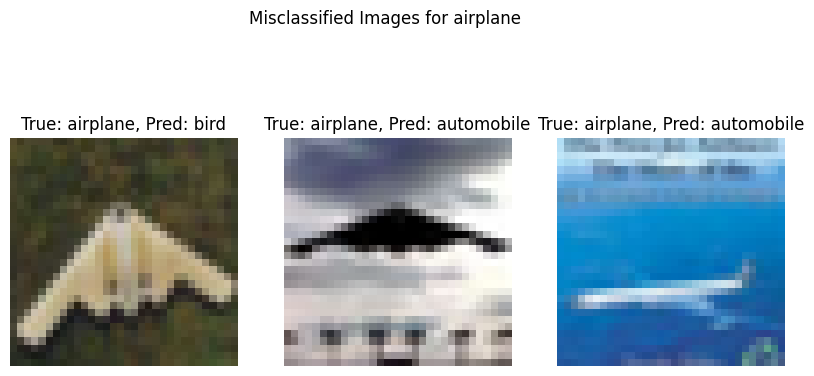

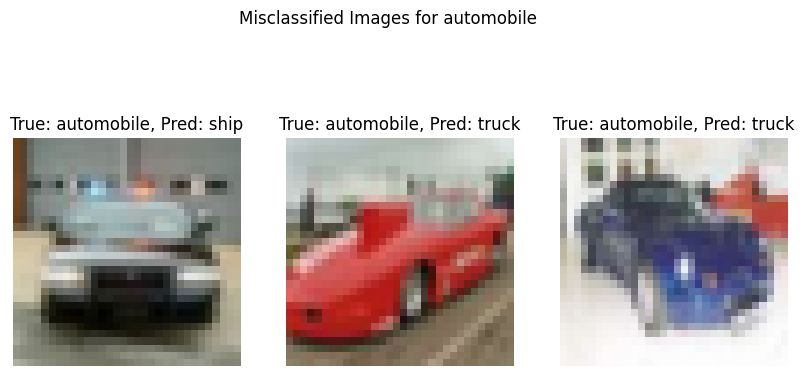

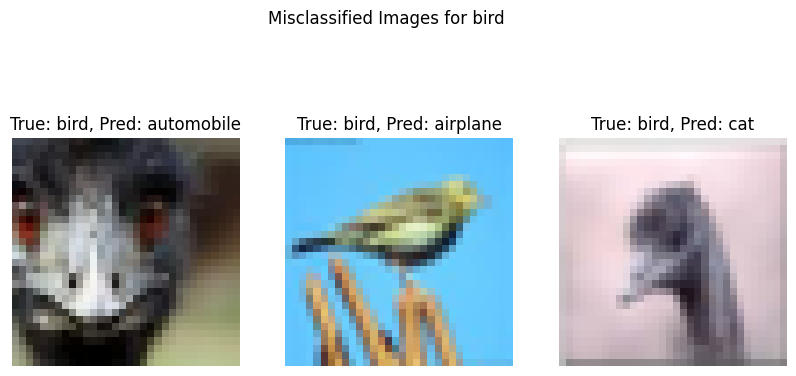

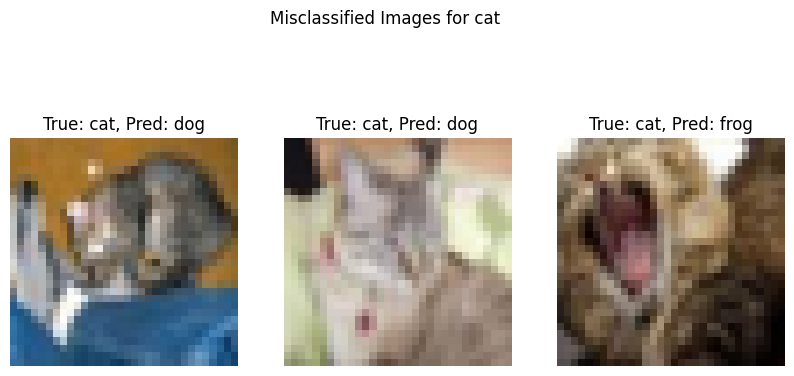

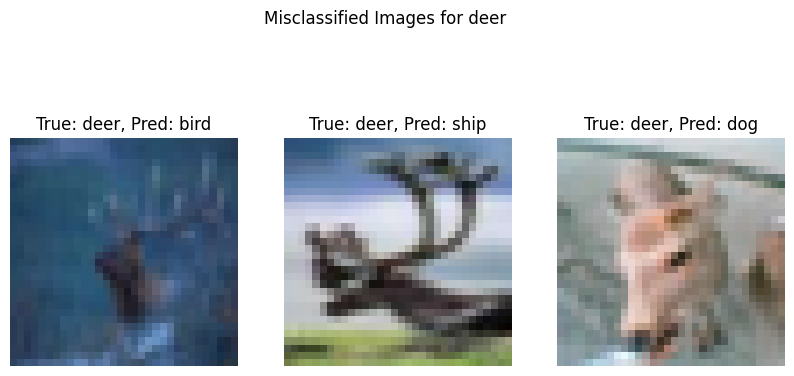

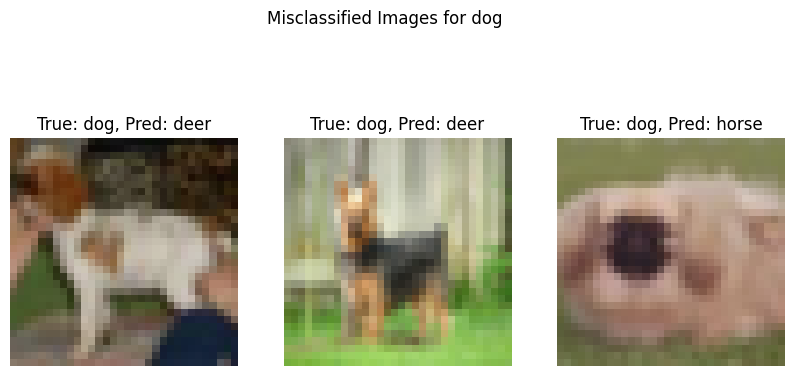

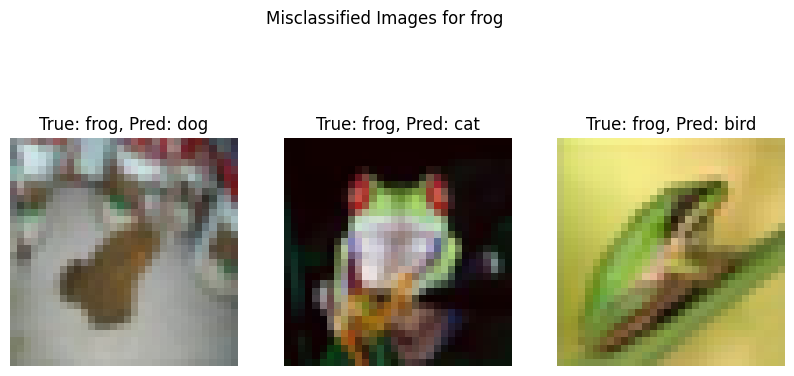

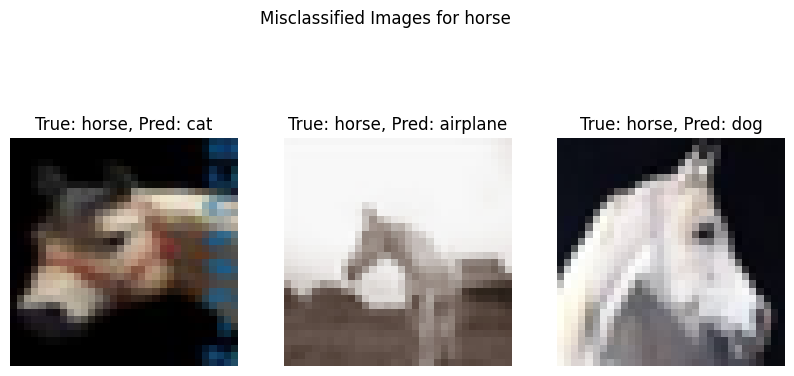

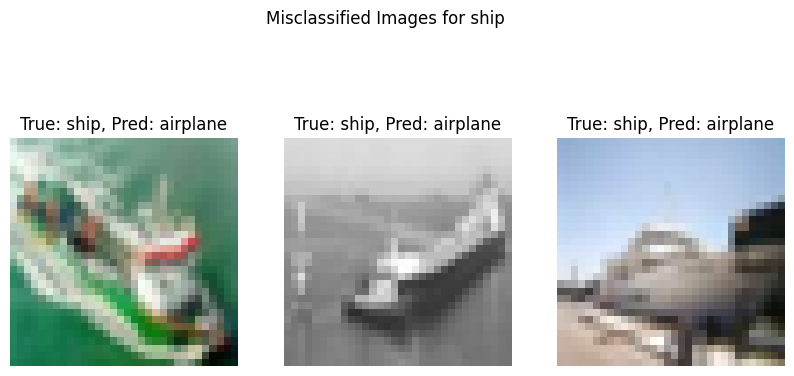

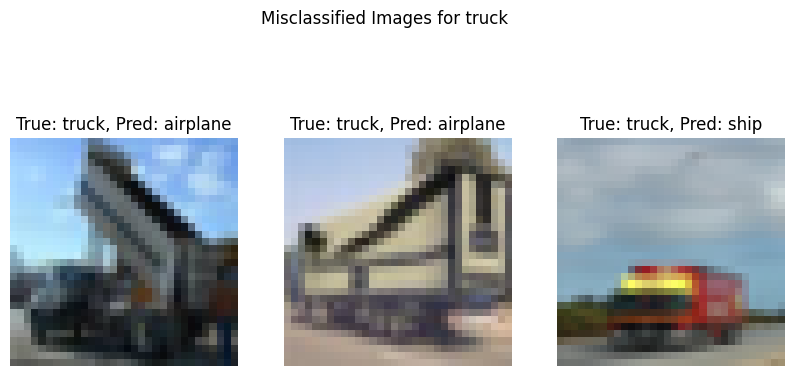

In [10]:
num_epochs = 150
loss_list = []
acc_list = []
train_acc_list = []

for epoch in range(num_epochs):
    net.train()
    correct_train = 0
    total_train = 0
    epoch_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100. * correct_train / total_train
    train_acc_list.append(train_accuracy)
    print(f'Epoch {epoch+1}: Loss: {epoch_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%')
    loss_list.append(epoch_loss/len(train_loader))

    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    misclassified_images = {i: [] for i in range(10)}
    misclassified_labels = {i: [] for i in range(10)}
    misclassified_preds = {i: [] for i in range(10)}

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            # 誤分類のデータを保存
            misclassified_idx = (predicted != labels).cpu().numpy()
            for idx in range(len(labels)):
                if misclassified_idx[idx] and len(misclassified_images[labels[idx].item()]) < 3:
                    misclassified_images[labels[idx].item()].append(inputs[idx].cpu())
                    misclassified_labels[labels[idx].item()].append(labels[idx].cpu().item())
                    misclassified_preds[labels[idx].item()].append(predicted[idx].cpu().item())

    test_accuracy = 100. * correct / total
    acc_list.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    # 混同行列の出力
    cm = confusion_matrix(y_true, y_pred)
    print(f'Confusion Matrix (Epoch {epoch+1}):')
    print(cm)

    # 最後のエポックのみ各クラスの誤った予測の画像を表示
    if epoch + 1 == num_epochs:
        for class_idx in range(10):
            if len(misclassified_images[class_idx]) > 0:
                fig, axes = plt.subplots(1, len(misclassified_images[class_idx]), figsize=(10, 5))
                fig.suptitle(f'Misclassified Images for {classes[class_idx]}')
                if len(misclassified_images[class_idx]) == 1:
                    axes = [axes]
                for idx, ax in enumerate(axes):
                    image = misclassified_images[class_idx][idx].permute(1, 2, 0) * 0.5 + 0.5  # データの正規化を戻す
                    label = misclassified_labels[class_idx][idx]
                    pred = misclassified_preds[class_idx][idx]

                    ax.imshow(image)
                    ax.set_title(f'True: {classes[label]}, Pred: {classes[pred]}')
                    ax.axis('off')
                plt.show()

    torch.save(net.state_dict(), f'Weight_Epoch{epoch+1}.pth')
    scheduler.step()

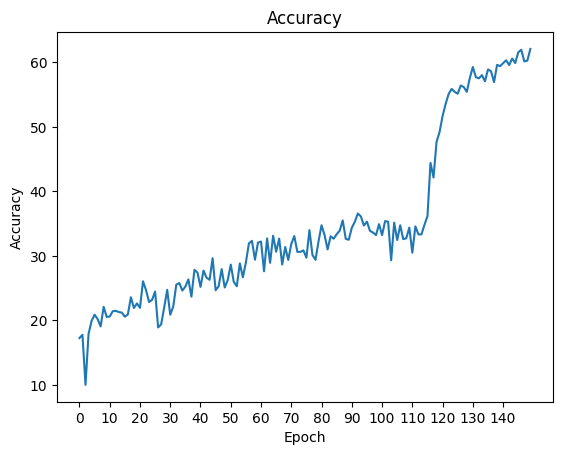

In [11]:
plt.plot(acc_list)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,150,10))
plt.ylabel('Accuracy')
plt.show()